In [1]:
from gw_signal_tools.waveform_utils import (
    td_to_fd_waveform, fd_to_td_waveform,
    pad_to_get_target_df, restrict_f_range,
    get_strain, fill_f_range, get_signal_at_target_df,
    get_signal_at_target_frequs
)

import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', '.*This code is currently UNREVIEWED, use with caution!.*')

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

# Waveform Conversion Verifications

First we need an example signal

In [3]:
# Define the dictionary
f_min = 20.*u.Hz
f_max = 1024.*u.Hz

parameters_gw150914 = {
    'mass1' : 36*u.solMass,
    'mass2' : 29*u.solMass,
    'deltaT' : 1./2048.*u.s,
    'deltaF': 2**-4*u.Hz,
    'f22_start' : f_min,  # Lower cutoff frequency
    'f22_ref': 20.*u.Hz,  # Frequency where spins are specified
    'f_max': f_max,
    'phi_ref' : 0.*u.rad,
    'distance' : 1.*u.Mpc,
    'inclination' : 0.0*u.rad,
    'eccentricity' : 0.*u.dimensionless_unscaled,
    'longAscNodes' : 0.*u.rad,
    'meanPerAno' : 0.*u.rad,
    'condition' : 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'

# Call the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


# Generate time domain waveform
hp_t, hc_t = wfm.GenerateTDWaveform(parameters_gw150914, gen)


# Two waveforms will be generated in frequency domain, first with finer
# sampling and then with coarser one
hp_f_fine, hc_f_fine = wfm.GenerateFDWaveform(parameters_gw150914, gen)
hp_f_fine.override_unit(u.s)
hc_f_fine.override_unit(u.s)

hp_f_coarse, hc_f_coarse = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)
hp_f_coarse.override_unit(u.s)
hc_f_coarse.override_unit(u.s)

## General Fourier Checks

In [4]:
from gw_signal_tools.test_utils import assert_allclose_series
from numpy.testing import assert_allclose

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


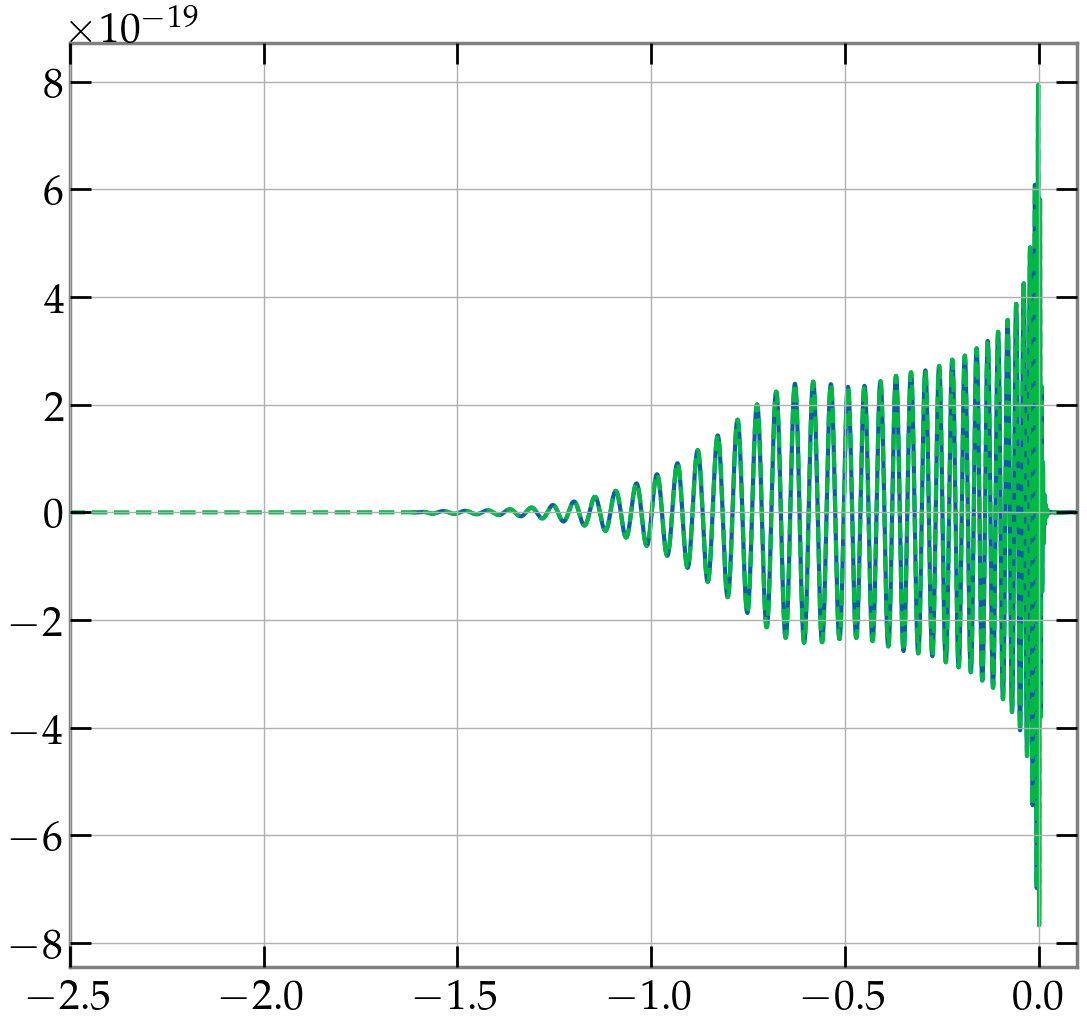

In [5]:

h_symm = td_to_fd_waveform(pad_to_get_target_df(hp_t, df=hp_f_fine.df) + 0.j)

h_symm_t = fd_to_td_waveform(h_symm)

plt.plot(hp_t)
plt.plot(h_symm_t, '--')

plt.xlim(-2.5, 0.1)

plt.show()

# t_min, t_max = max(hp_t.times[0], h_symm_t.times[0]), min(hp_t.times[-1], h_symm_t.times[-1])
# # assert_allclose_series(hp_t.crop(t_min, t_max)[1:-1], h_symm_t.crop(t_min, t_max)[1:-1], atol=5e-27, rtol=1e-8)
# assert_allclose(hp_t.crop(t_min, t_max).value, h_symm_t.crop(t_min, t_max).value, atol=5e-27, rtol=0)


Demonstration of Time Shifting

In [6]:
time_shift = 1.*u.s
hp_f_time_shifted = hp_f_fine * np.exp(-1.j*2.*np.pi*hp_f_fine.frequencies*time_shift)

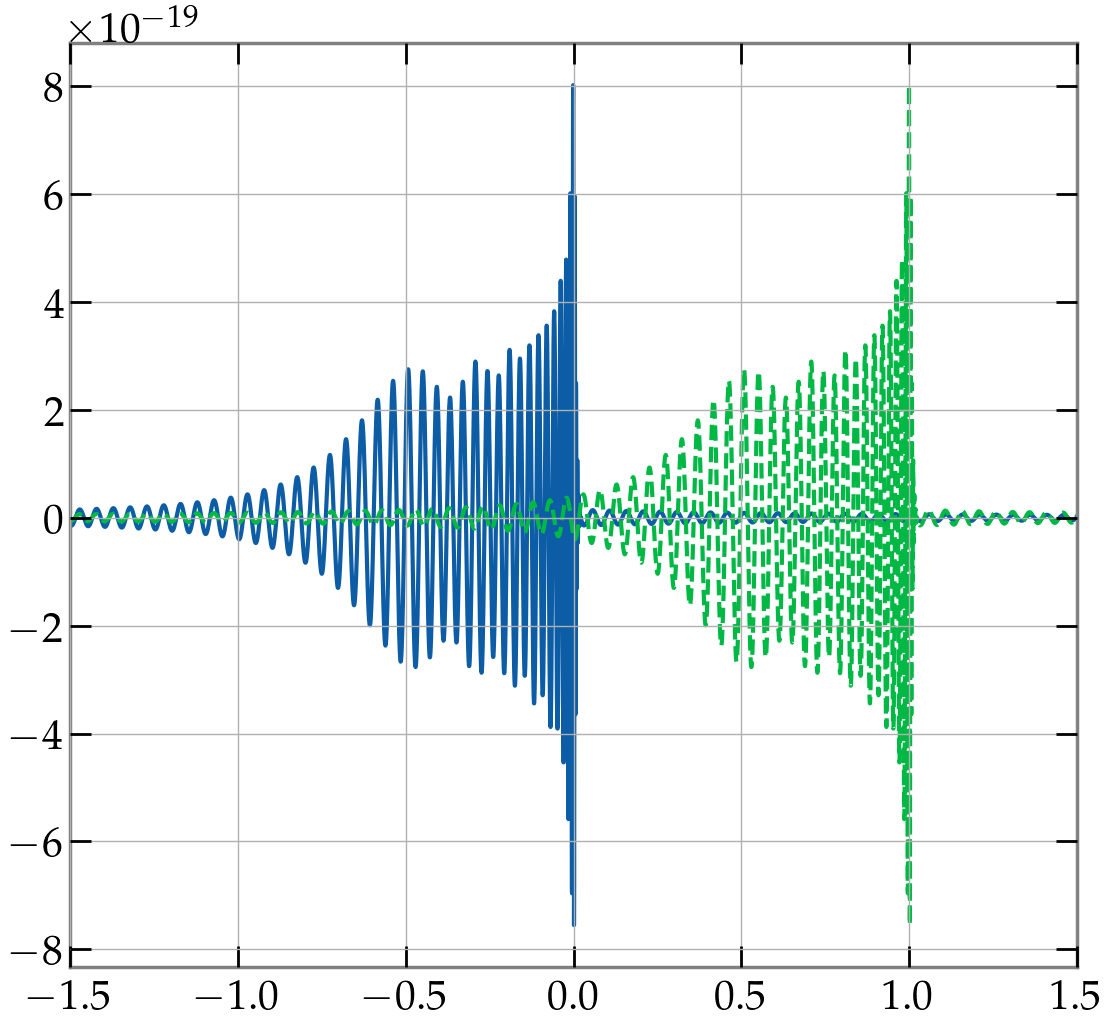

In [7]:
plt.plot(fd_to_td_waveform(hp_f_fine))
plt.plot(fd_to_td_waveform(hp_f_time_shifted), '--')

plt.xlim(-1.5, 1.5)

plt.show()

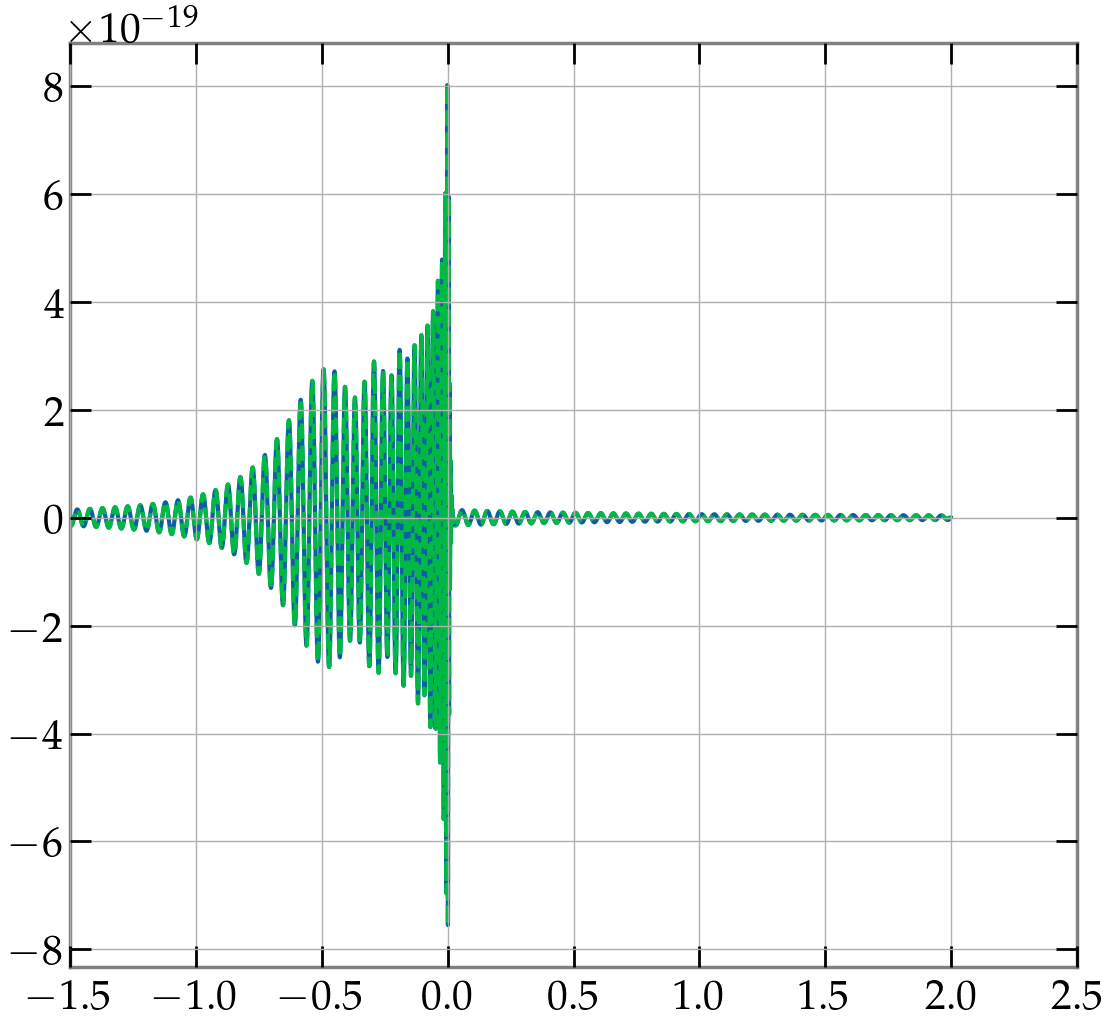

In [8]:
hp_f_fine_tapered = fd_to_td_waveform(hp_f_fine).taper()
# hp_f_fine_tapered = fd_to_td_waveform(hp_f_fine).taper(nsamples=len(hp_f_fine)//2)

# Seemingly does nothing...

plt.plot(fd_to_td_waveform(hp_f_fine))
plt.plot(hp_f_fine_tapered, '--')

# plt.xlim(-1.5, 1.5)
plt.xlim(-1.5, 2.5)

plt.show()

In [9]:
import numpy as np
from gwpy.frequencyseries import FrequencySeries

h_symm = FrequencySeries(
    np.flip(np.conjugate(hp_f_fine)[1:]),
    f0=-hp_f_fine.frequencies[-1],
    df=hp_f_fine.df
).append(hp_f_fine, inplace=True)
# h_symm = get_strain(parameters_gw150914, 'frequency', gen, mode='mixed')

h_symm_t = fd_to_td_waveform(h_symm)
# h_symm_t = get_strain(parameters_gw150914, 'time', gen, mode='mixed')

# t_min, t_max = max(hp_t.times[0], h_symm_t.times[0]), min(hp_t.times[-1], h_symm_t.times[-1])

# h_symm_t.t0 = hp_t.t0
h_symm_f = td_to_fd_waveform(h_symm_t+0.j)
# h_symm_f = td_to_fd_waveform(h_symm_t.crop(start=hp_t.t0))

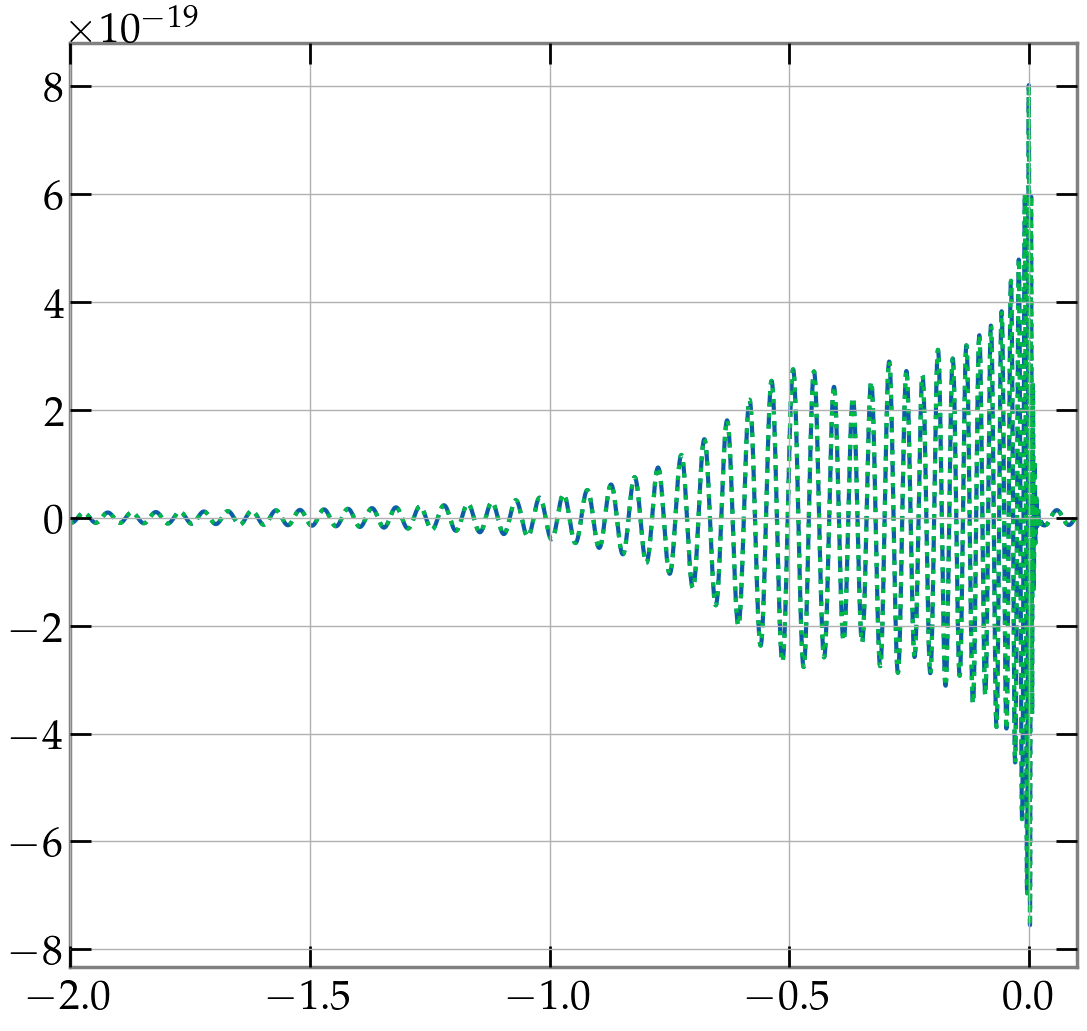

In [10]:
# plt.plot(hp_t)
plt.plot(h_symm_t, '--')
plt.plot(fd_to_td_waveform(hp_f_fine), ':')

plt.xlim(-2., 0.1)
# plt.xlim(-0.5, 0.1)

plt.show()

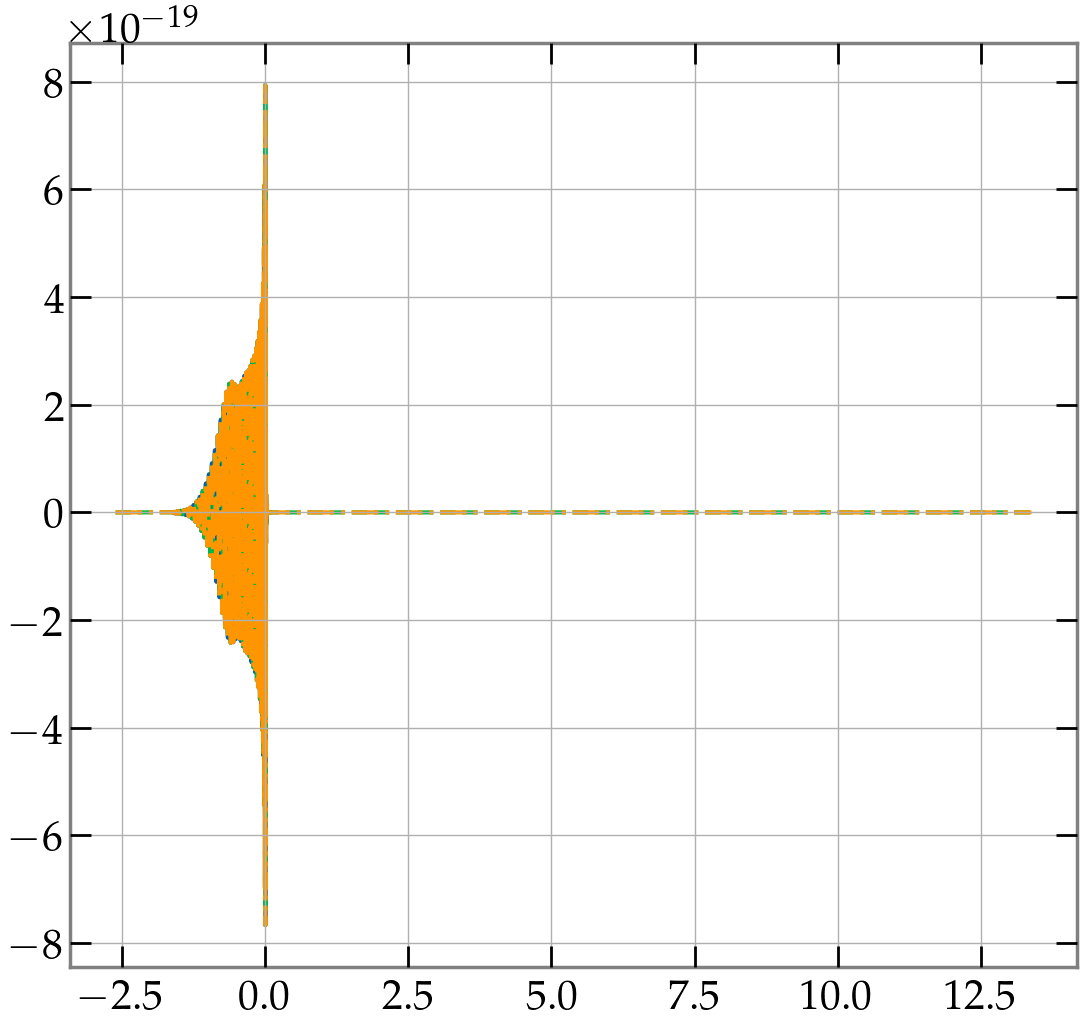

In [11]:
plt.plot(hp_t)
# plt.plot(fd_to_td_waveform(td_to_fd_waveform(hp_t)), '--')
# plt.plot(fd_to_td_waveform(td_to_fd_waveform(hp_t+0.j)), '-.')  # Has double-sided Fourier spectrum

plt.plot(fd_to_td_waveform(td_to_fd_waveform(pad_to_get_target_df(hp_t, hp_f_fine.df))), '--')
plt.plot(fd_to_td_waveform(td_to_fd_waveform(pad_to_get_target_df(hp_t, hp_f_fine.df)+0.j)), '-.')  # Has double-sided Fourier spectrum

plt.show()

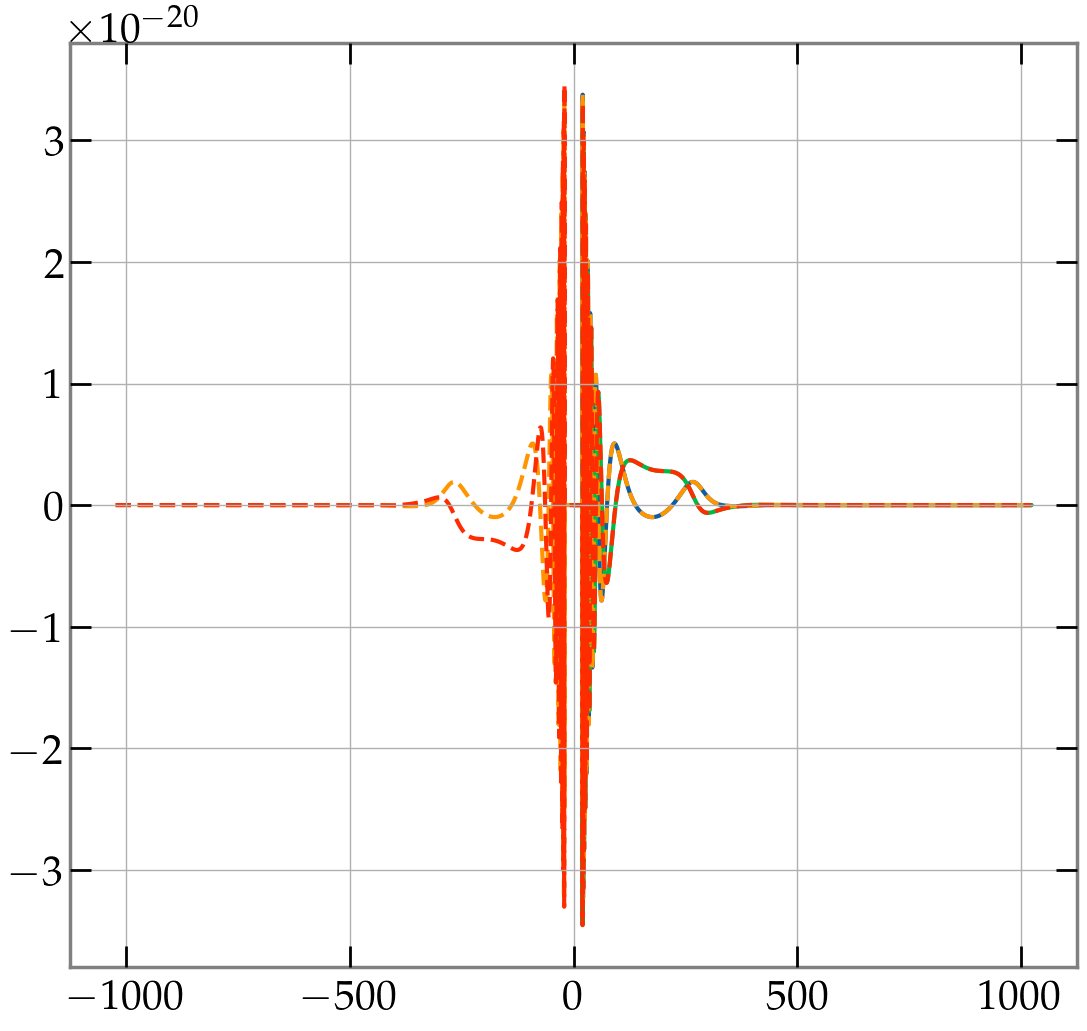

In [12]:
plt.plot(hp_f_fine)
plt.plot(hp_f_fine.imag)
# plt.plot(hp_f_fine.abs())

plt.plot(h_symm_f, '--')
plt.plot(h_symm_f.imag, '--')
# plt.plot(h_symm_f.abs(), '--')
# plt.plot(td_to_fd_waveform(hp_t), ':')
# plt.plot(td_to_fd_waveform(hp_t+0.j), ':')

# plt.xlim(18, 42)
# plt.xlim(18, 60)

plt.show()

Hm, shit. Absolute values equal, but phase seems to be off...

In [13]:
h_symm = td_to_fd_waveform(pad_to_get_target_df(hp_t, df=hp_f_fine.df) + 0.j)
    
h_symm_t = fd_to_td_waveform(h_symm)

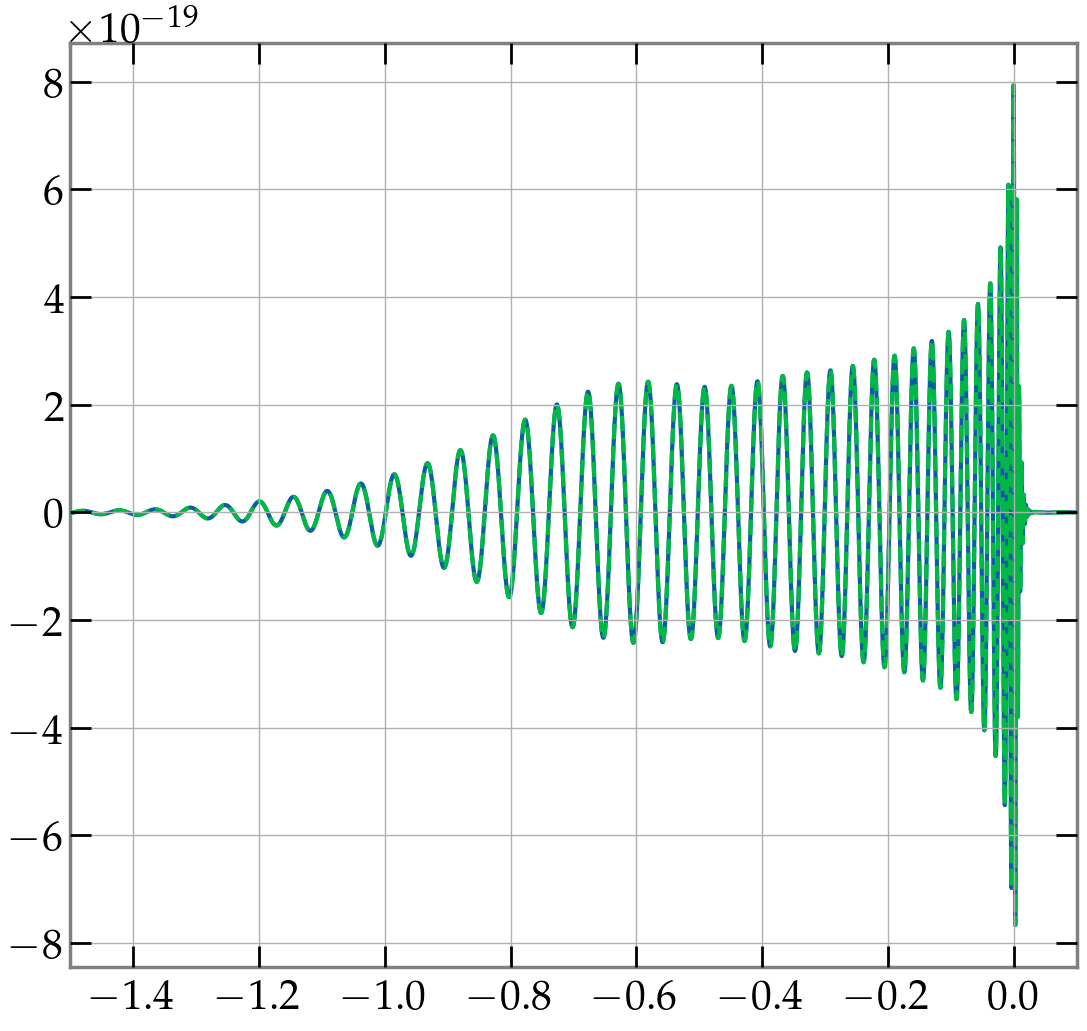

In [14]:
plt.plot(hp_t)
plt.plot(h_symm_t, '--')

plt.xlim(-1.5, 0.1)

plt.show()

## Sanity Checks

Transforming to one domain and back must yield the same waveform, up to essentially numerical precision

### Frequency Domain

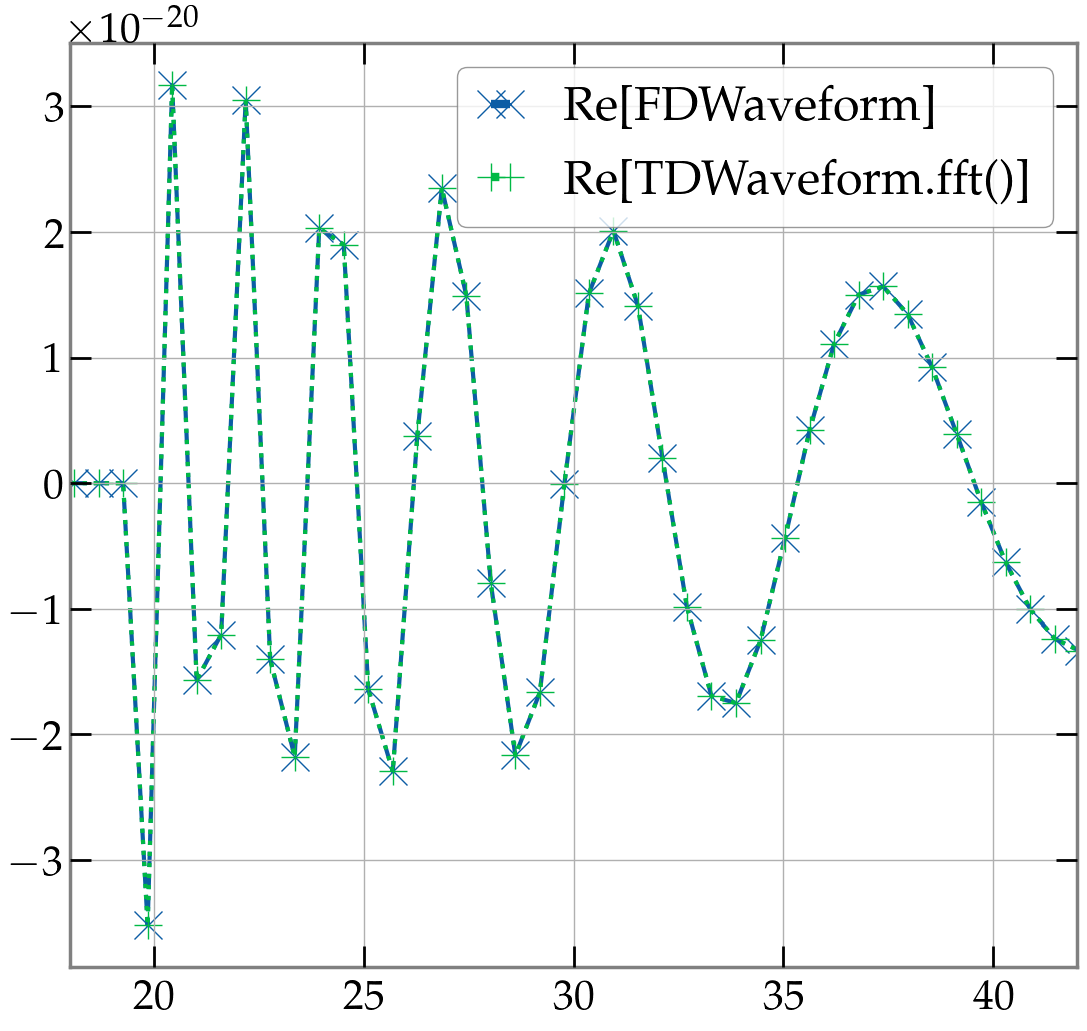

In [15]:
fig, ax = plt.subplots()

ax.plot(hp_f_coarse.real, 'x--', label='Re[FDWaveform]')

ax.plot(td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse)).real, '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([18, 42])
# ax.set_xlim([0, 256])

plt.show()

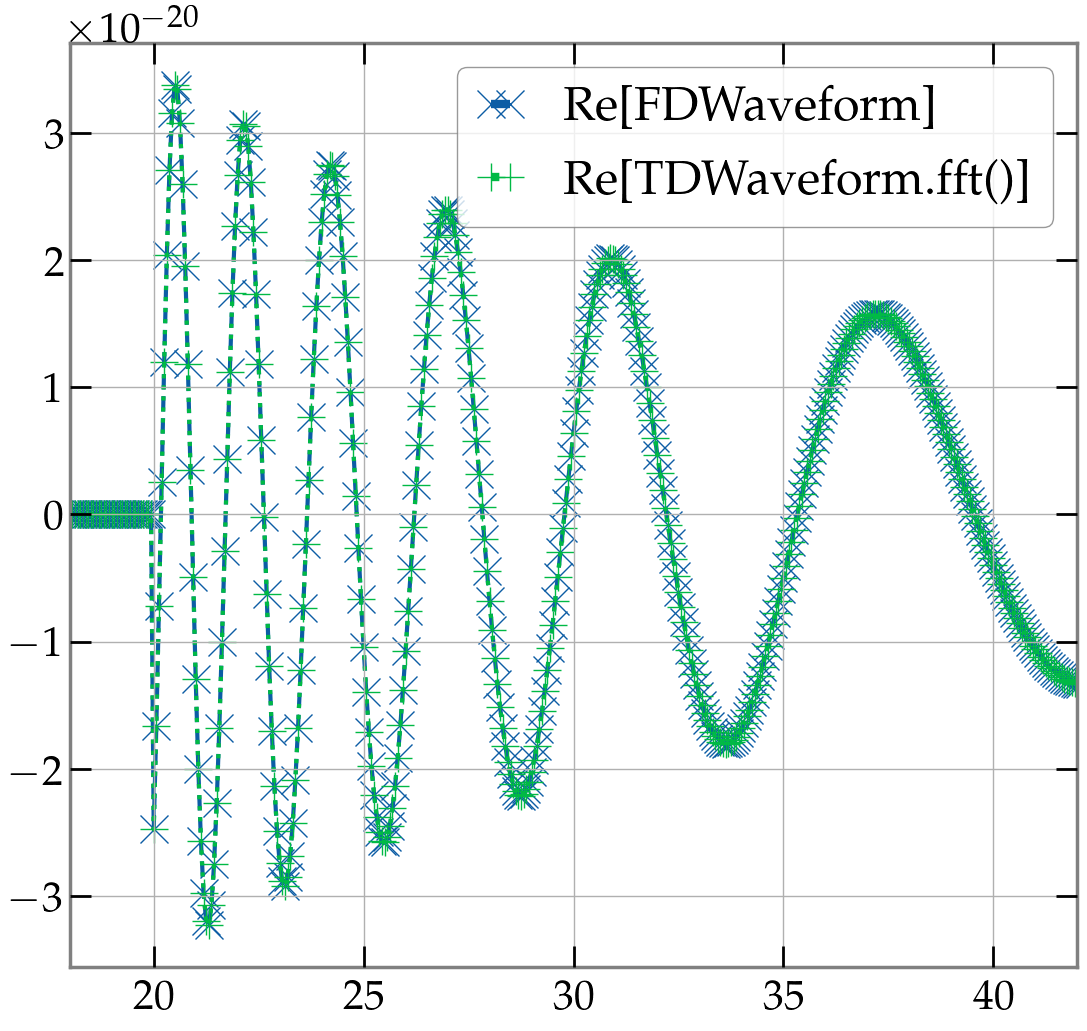

In [16]:
fig, ax = plt.subplots()

ax.plot(hp_f_fine.real, 'x--', label='Re[FDWaveform]')

ax.plot(td_to_fd_waveform(fd_to_td_waveform(hp_f_fine)).real, '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([18, 42])
# ax.set_xlim([0, 256])

plt.show()

In [17]:
f_min_comp, f_max_comp = 20.0 * u.Hz, 512.0 * u.Hz  # Restrict to interesting region, elsewhere only values close to zero and thus numerical errors might occur

print(np.all(np.isclose(np.real(hp_f_coarse.crop(start=f_min_comp, end=f_max_comp)), np.real(td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse)).crop(start=f_min_comp, end=f_max_comp)), atol=0.0, rtol=0.001)))
print(np.all(np.isclose(np.real(hp_f_fine.crop(start=f_min_comp, end=f_max_comp)), np.real(td_to_fd_waveform(fd_to_td_waveform(hp_f_fine)).crop(start=f_min_comp, end=f_max_comp)), atol=0.0, rtol=0.001)))

True
True


Equal up to at least 0.1%

For a visual proof of that we plot the absolute differences

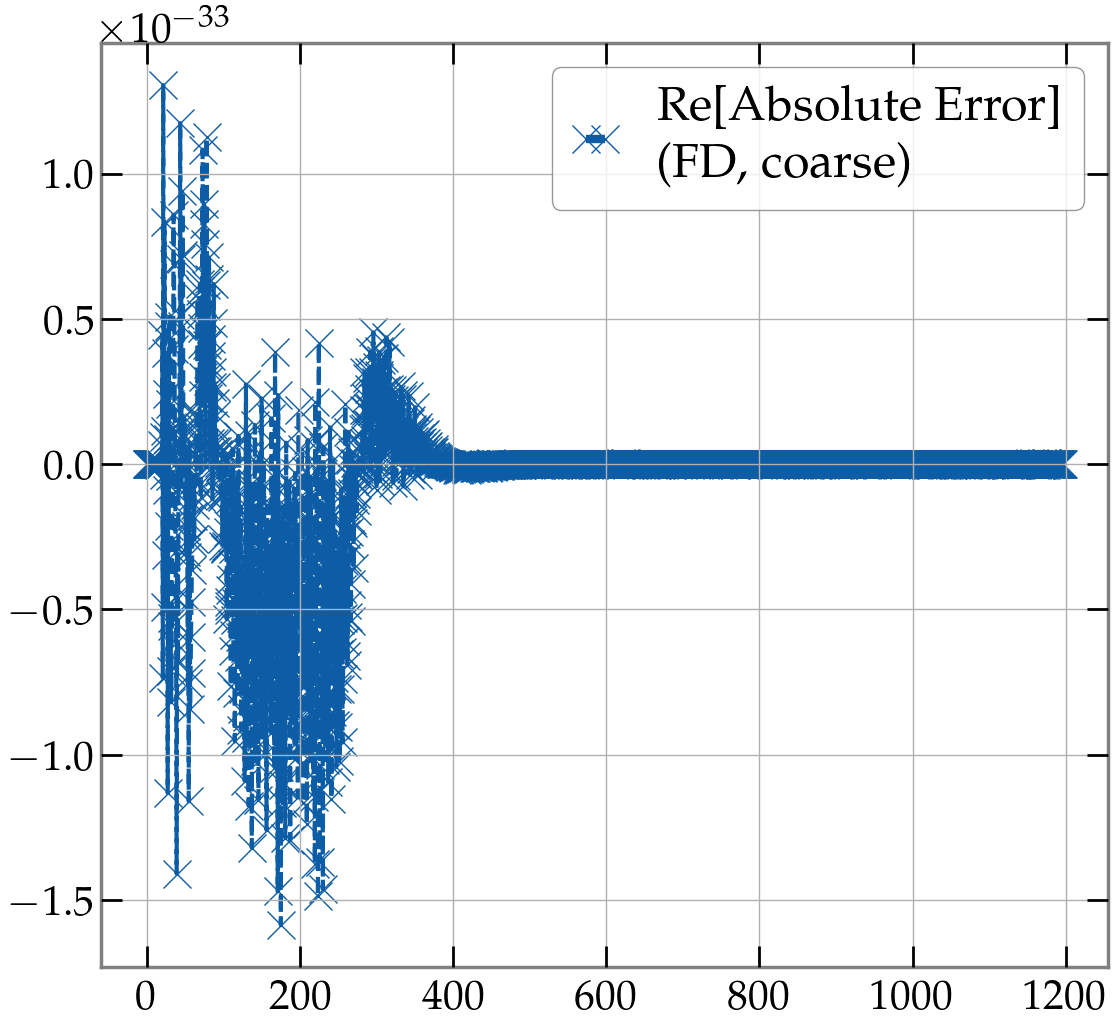

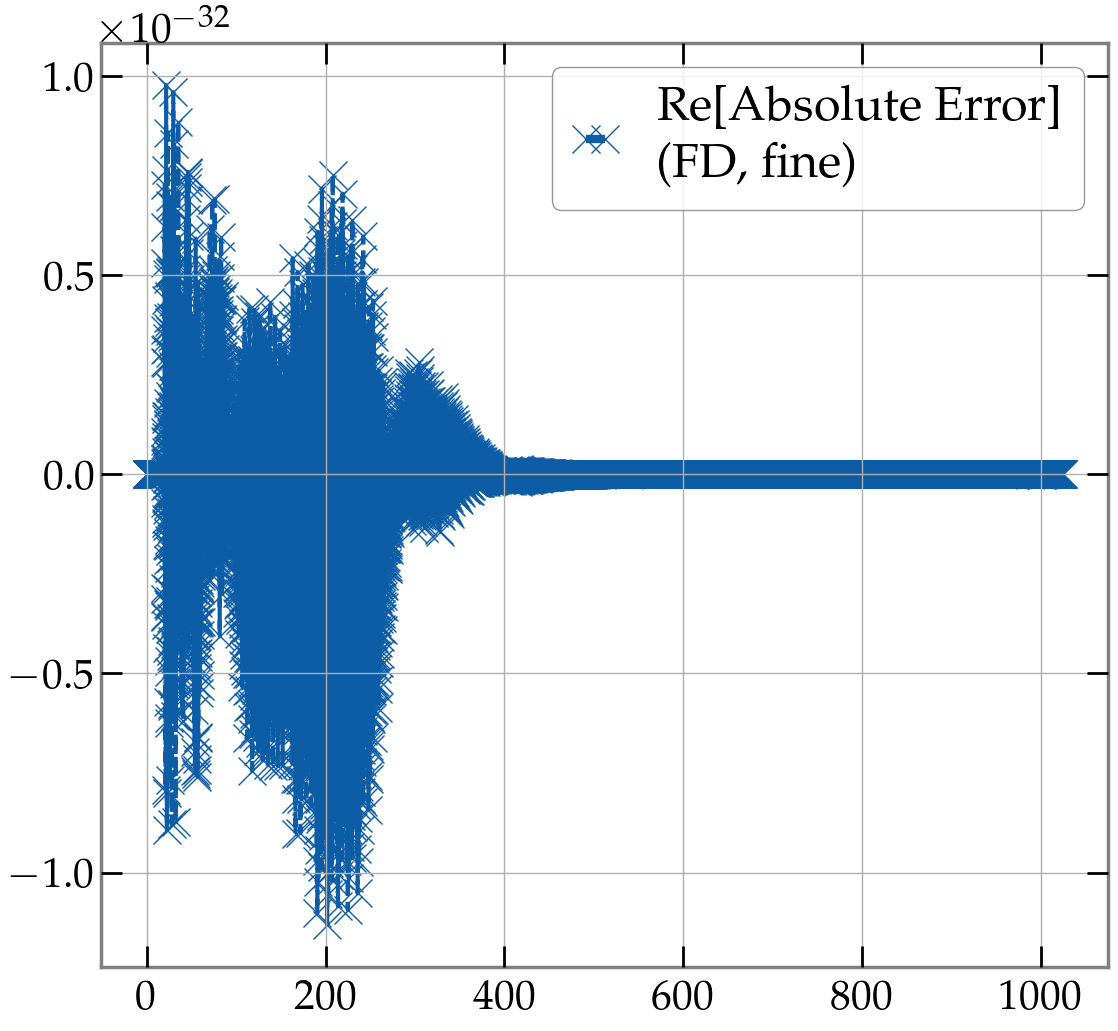

In [18]:
fig, ax = plt.subplots()

ax.plot((hp_f_coarse - td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse))).real, 'x--', label='Re[Absolute Error]\n(FD, coarse)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()



fig, ax = plt.subplots()

ax.plot((hp_f_fine - td_to_fd_waveform(fd_to_td_waveform(hp_f_fine))).real, 'x--', label='Re[Absolute Error]\n(FD, fine)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

These are essentially random errors, especially for first plot one can see no systematic in error signal

### Time Domain

In [19]:
hp_t_2 = hp_t.copy()
# hp_t_2.epoch = 0
hp_t_fft_ifft = fd_to_td_waveform(td_to_fd_waveform(hp_t_2))

In [20]:
fd_to_td_waveform(td_to_fd_waveform(hp_t_2)).epoch

<Time object: scale='utc' format='gps' value=-2.6152343750041496>

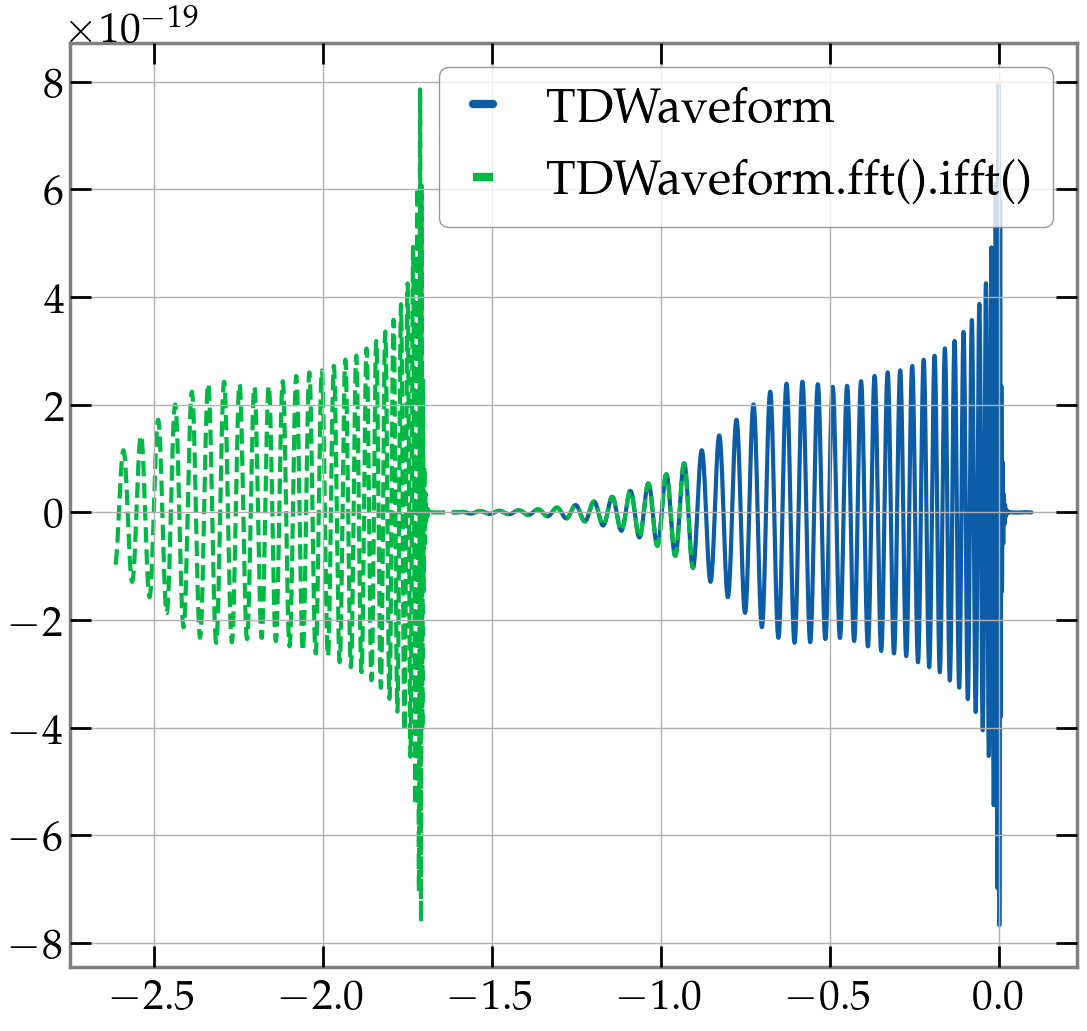

In [21]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_fft_ifft, '--', label='TDWaveform.fft().ifft()')

ax.legend()

# ax.set_xlim([-0.75, 0.1])
# ax.set_xlim([-0.1, 0.025])

plt.show()

Good agreement, apart from different end and start points everything is roughly equal. When zooming in, a slight phase shift can be observed, which makes sense given the rather raw sampling in frequency domain that this coarsely sampled signal represents (see signal in frequency domain).

-> now we observe wrap-around, makes sense because epoch is almost whole duration of signal, so wrapping with it causes problems

This must not change for smaller df.

In [22]:
hp_t_fft_ifft_fine = fd_to_td_waveform(td_to_fd_waveform(pad_to_get_target_df(hp_t, df=0.0625 * u.Hz)))

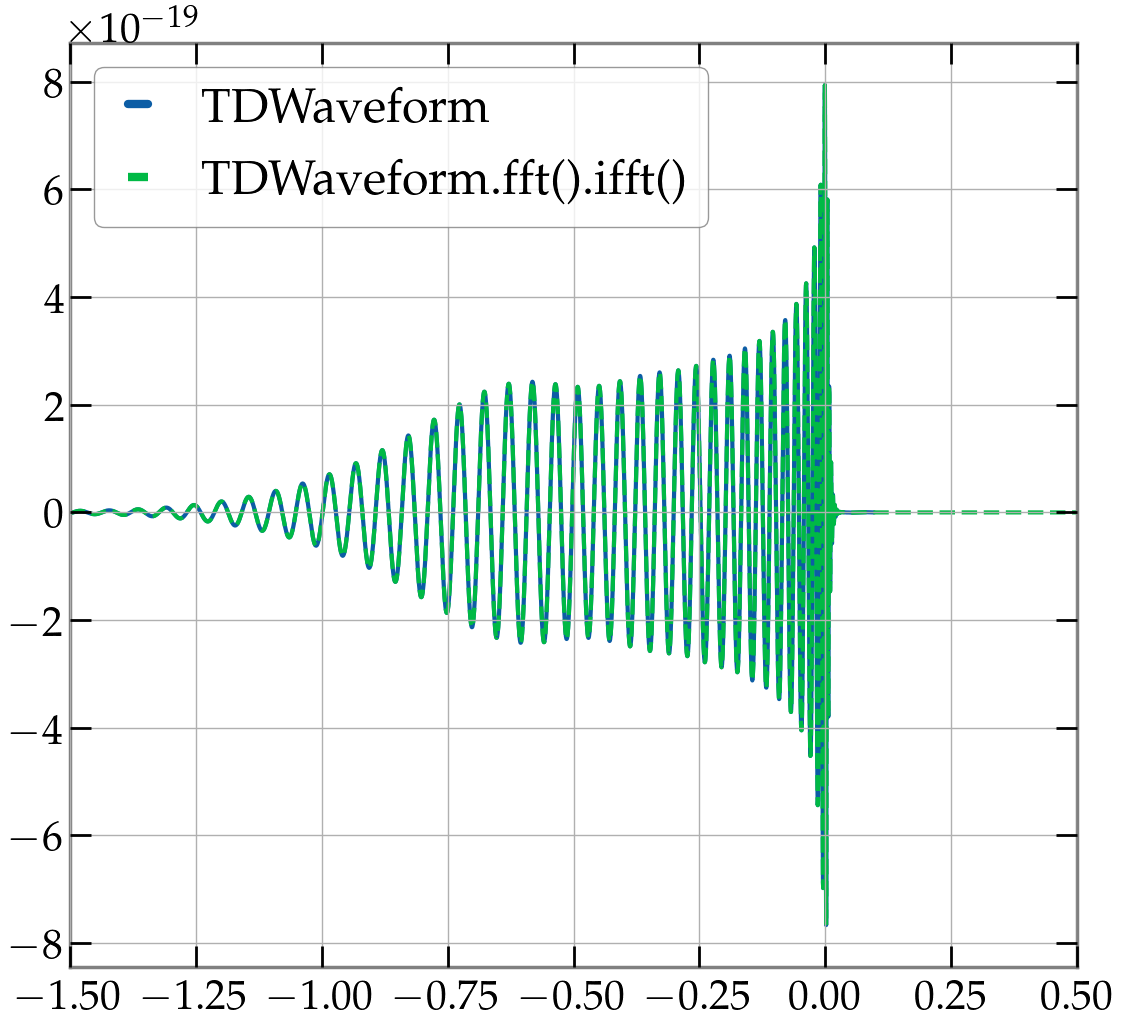

In [23]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_fft_ifft_fine, '--', label='TDWaveform.fft().ifft()')

ax.legend()

ax.set_xlim([-1.5, 0.5])
# ax.set_xlim([-0.1, 0.025])

plt.show()

In [24]:
t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft_fine.t0), min(hp_t.times[-1], hp_t_fft_ifft_fine.times[-1])  # hp_t_fft_ifft_fine is padded to be much longer

print(np.all(np.isclose(hp_t.crop(start=t_min_comp, end=t_max_comp)[1:], hp_t_fft_ifft_fine.crop(start=t_min_comp, end=t_max_comp)[1:], atol=0.0, rtol=0.001)))
# Note: for some reason, first sample is not equal. Thus excluded here

True


Equal up to at least 0.1% for fine sampling. For coarse sampling, the following plot of absolute deviations shows a maximum amplitude error of roughly 10% prior to the signal. Of course, this is a substantial deviation, which shows the need for sufficiently fine sampling.

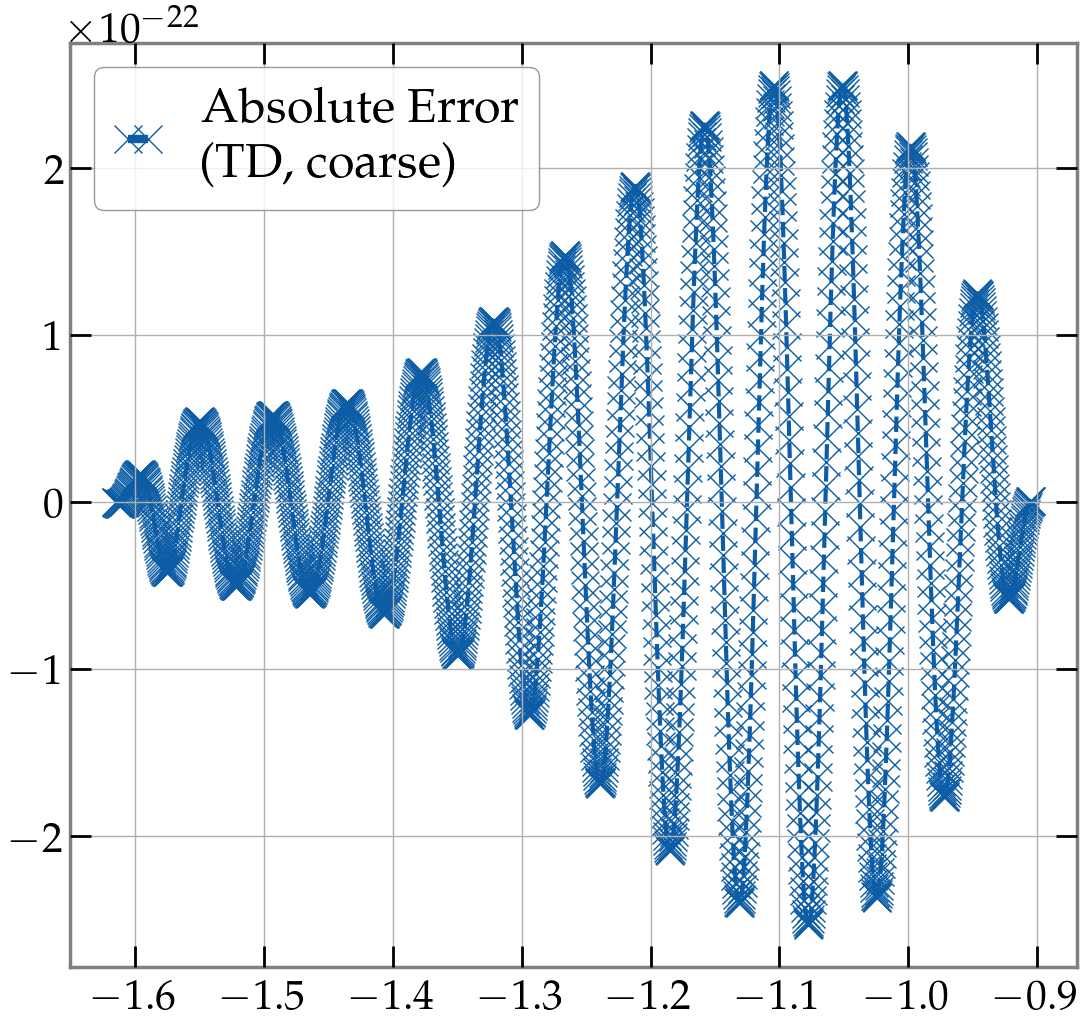

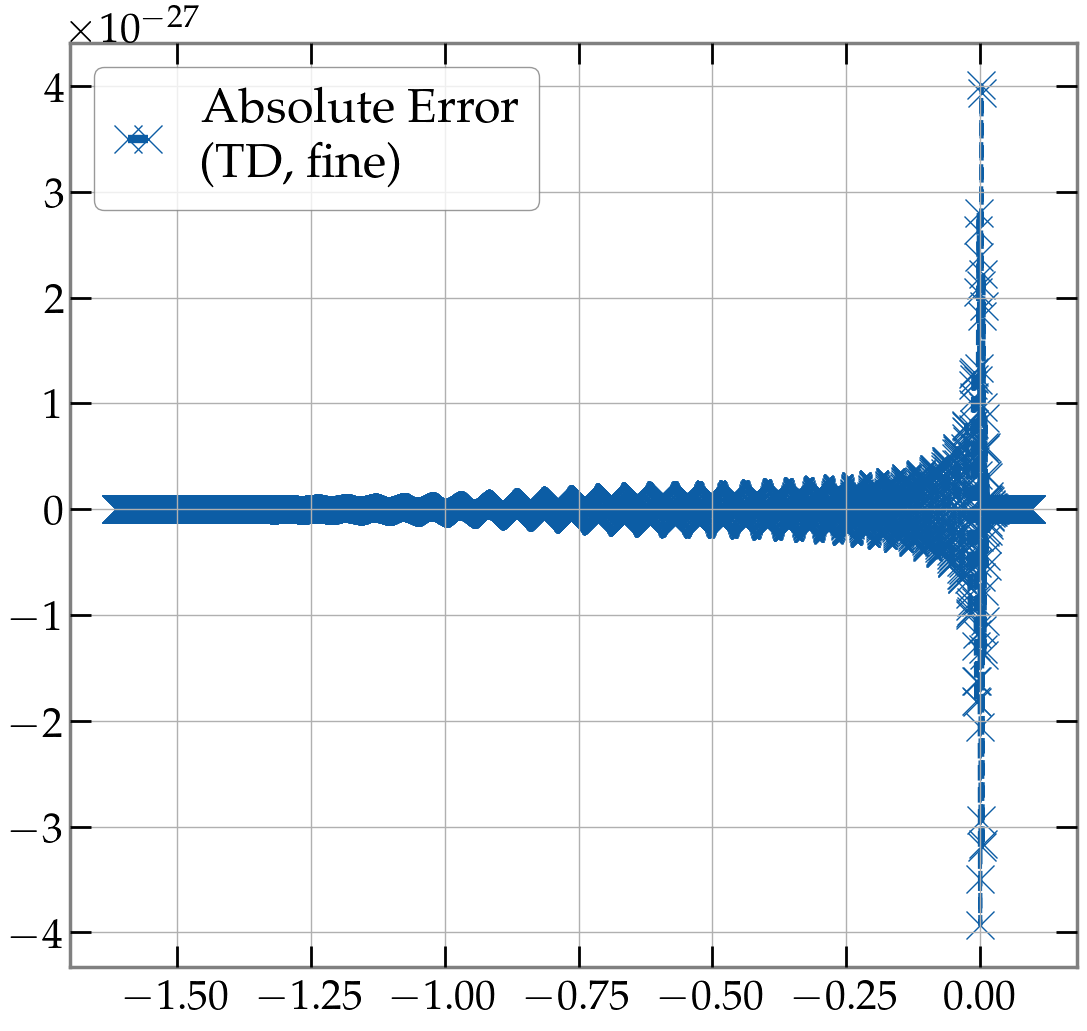

In [25]:
t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft.t0), min(hp_t.times[-1], hp_t_fft_ifft.times[-1])


fig, ax = plt.subplots()

ax.plot(hp_t.crop(start=t_min_comp, end=t_max_comp) - hp_t_fft_ifft.crop(start=t_min_comp, end=t_max_comp)[:-1], 'x--', label='Absolute Error\n(TD, coarse)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()



t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft_fine.t0), min(hp_t.times[-1], hp_t_fft_ifft_fine.times[-1])

fig, ax = plt.subplots()

ax.plot(hp_t.crop(start=t_min_comp, end=t_max_comp) - hp_t_fft_ifft_fine.crop(start=t_min_comp, end=t_max_comp), 'x--', label='Absolute Error\n(TD, fine)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

## Time Domain to Frequency Domain

- TODO for each: make zoom only in inset

Now we compare how well the FDWaveform generated by lal and our transformed TDWaveform agree

In [26]:
hp_t_f_coarse = td_to_fd_waveform(hp_t)

# For a finer resolution, we have to pad signal
hp_t_padded = pad_to_get_target_df(hp_t, df=hp_f_fine.df)
hp_t_f_fine = td_to_fd_waveform(hp_t_padded)

In [27]:
print(hp_f_coarse.df, hp_t_f_coarse.df)

print(hp_f_fine.df, hp_t_f_fine.df)

0.5839749073282008 Hz 0.5839749073282008 1 / s
0.0625 Hz 0.0625 1 / s


This demonstrates that `pad_to_get_target_df` does its job

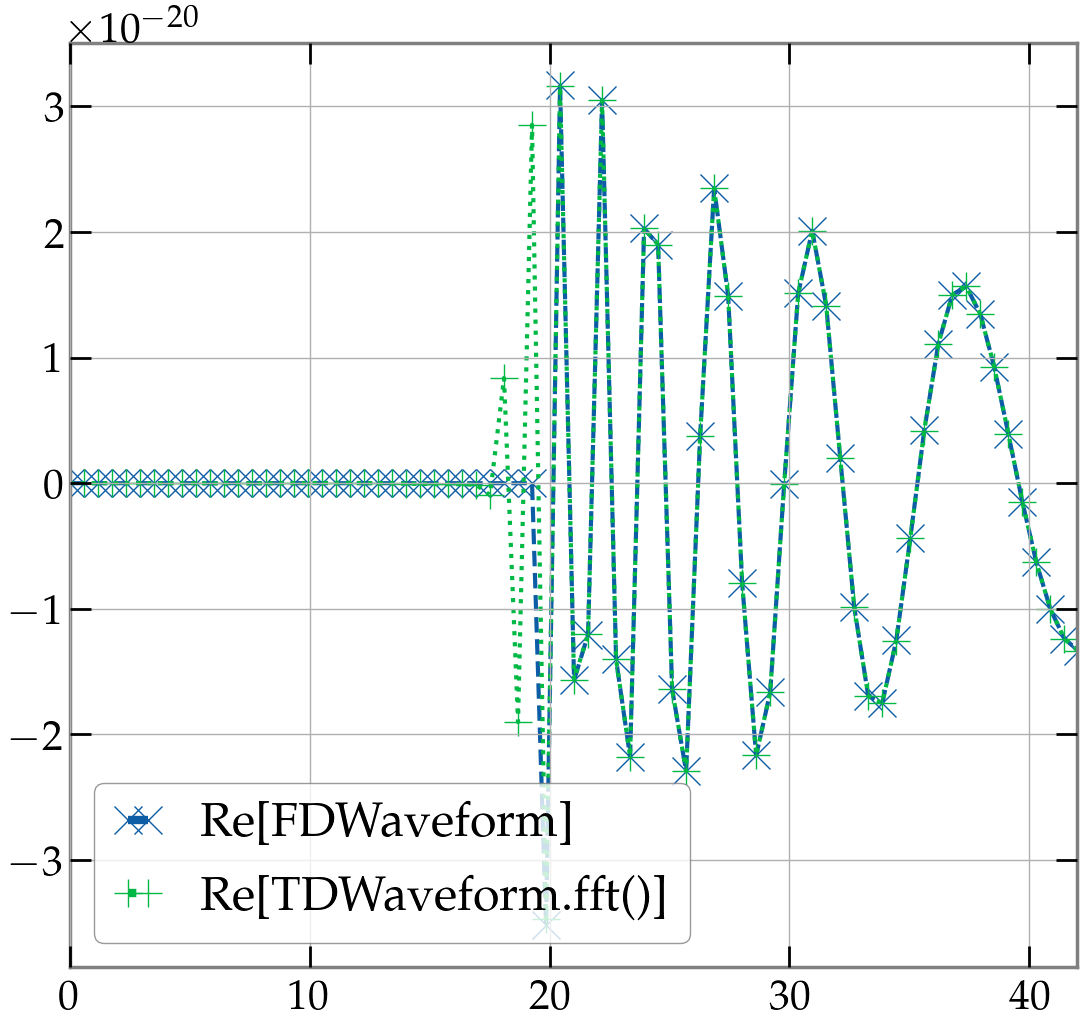

In [28]:
fig, ax = plt.subplots()

ax.plot(hp_f_coarse.real, 'x--', label='Re[FDWaveform]')

ax.plot(hp_t_f_coarse.real, '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

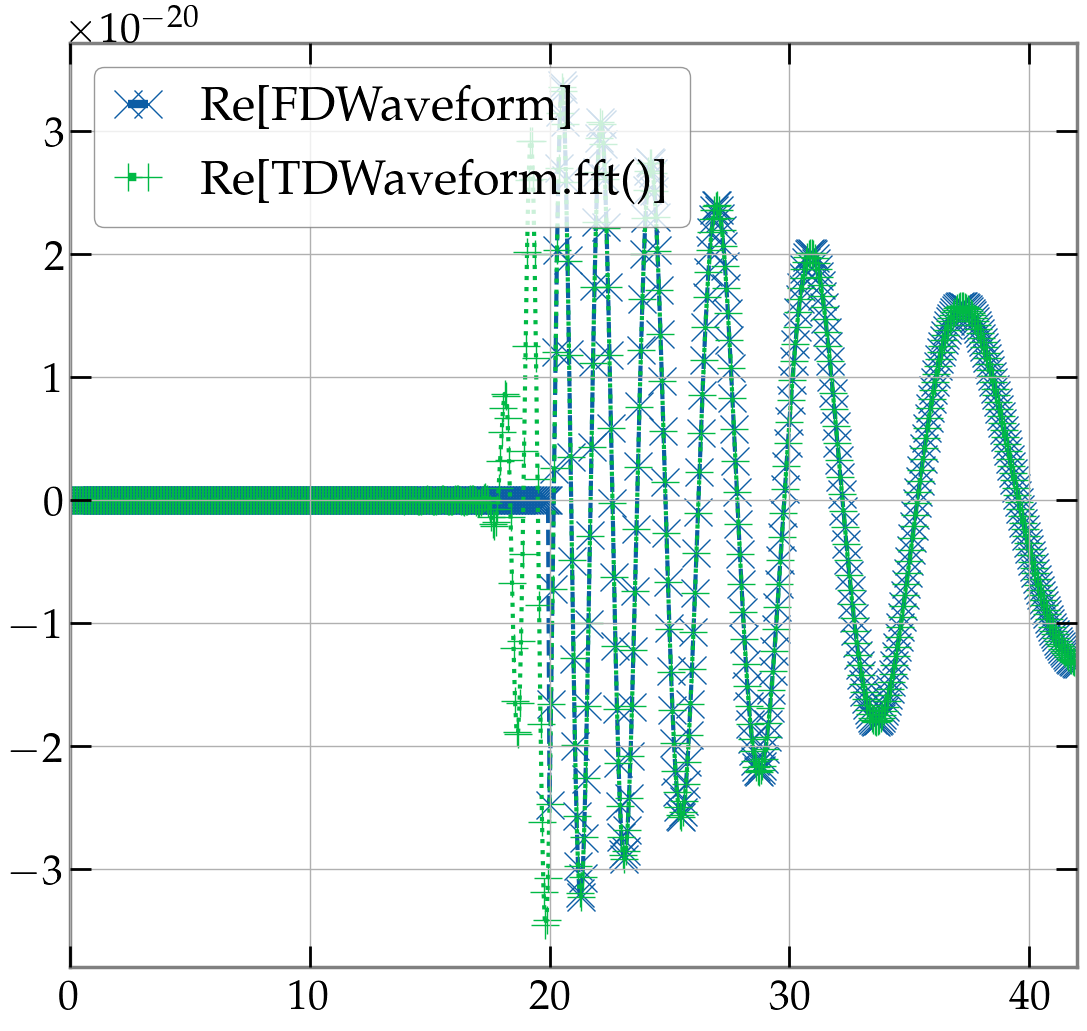

In [29]:
fig, ax = plt.subplots()

ax.plot(hp_f_fine.real, 'x--', label='Re[FDWaveform]')

ax.plot(hp_t_f_fine.real, '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

In [30]:
f_min_comp, f_max_comp = 25.0 * u.Hz, 512.0 * u.Hz  # Restrict to interesting region, elsewhere only values close to zero and thus numerical errors might occur

print(np.all(np.isclose(hp_f_coarse.crop(start=f_min_comp, end=f_max_comp), hp_t_f_coarse.crop(start=f_min_comp, end=f_max_comp), atol=0.0, rtol=0.01)))
print(np.all(np.isclose(hp_f_fine.crop(start=f_min_comp, end=f_max_comp), hp_t_f_fine.crop(start=f_min_comp, end=f_max_comp), atol=0.0, rtol=0.01)))

True
True


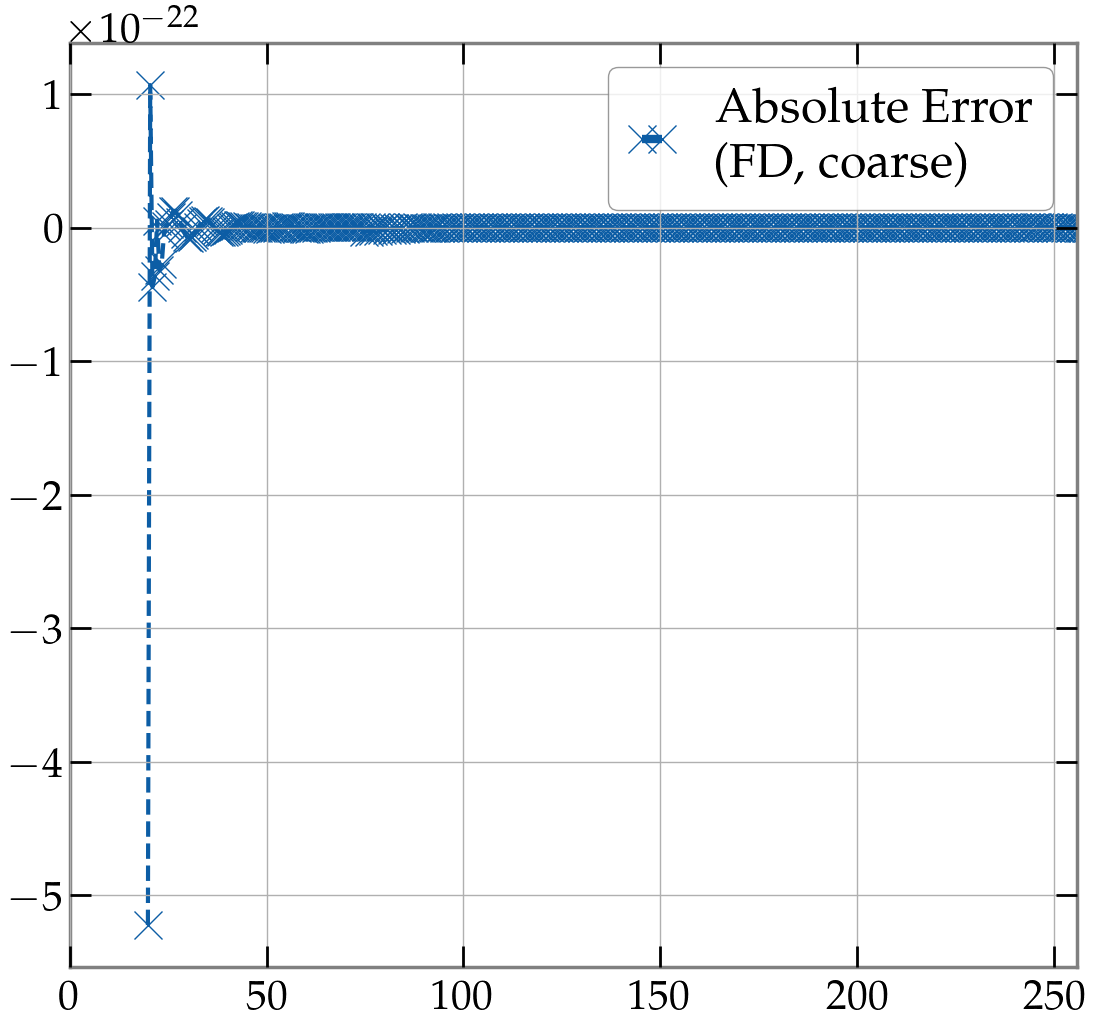

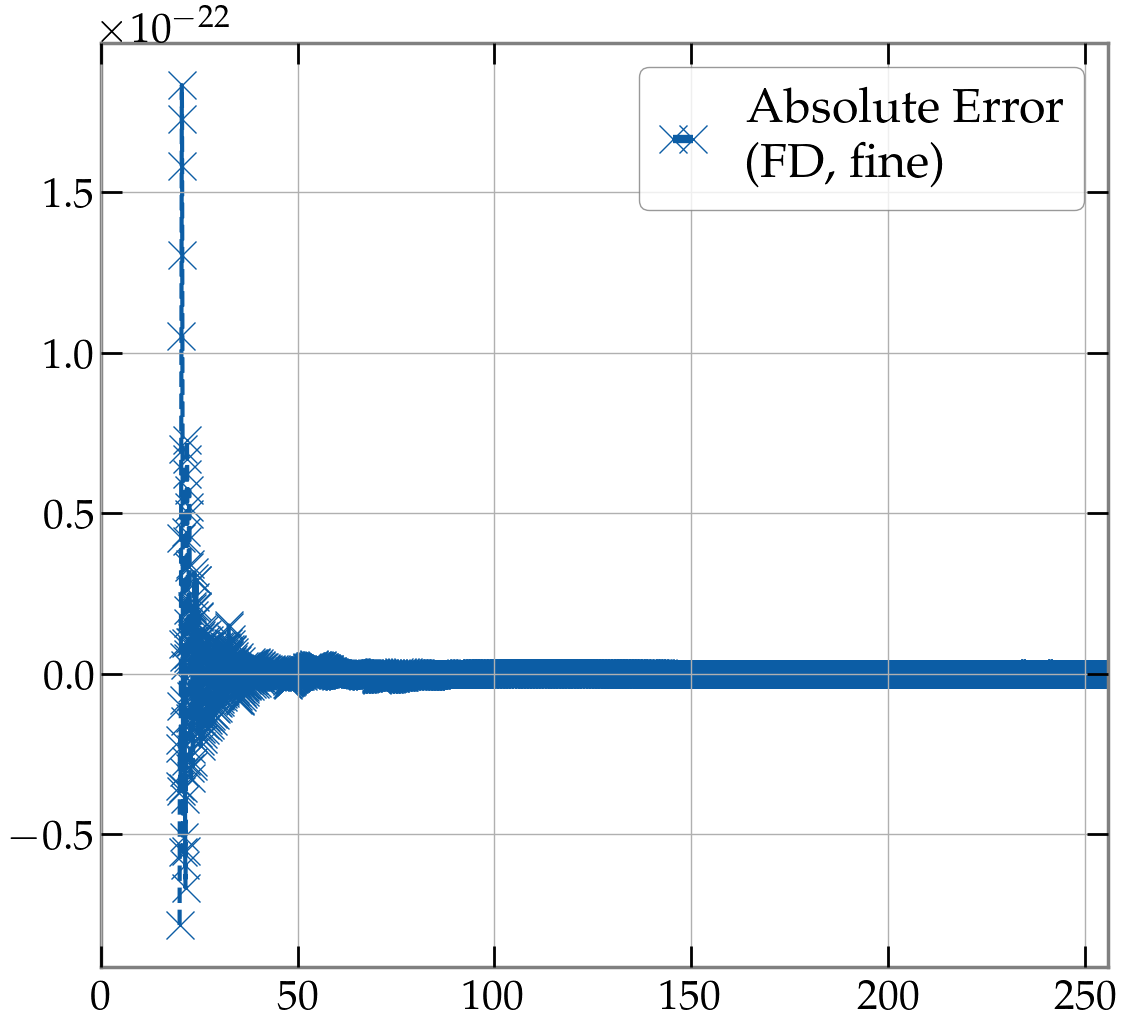

In [31]:
f_min_comp, f_max_comp = 20.0 * u.Hz, 512.0 * u.Hz  # Restrict to interesting region, elsewhere only values close to zero and thus numerical errors might occur


fig, ax = plt.subplots()

ax.plot((hp_f_coarse.crop(start=f_min_comp, end=f_max_comp) - hp_t_f_coarse.crop(start=f_min_comp, end=f_max_comp)).real, 'x--', label='Absolute Error\n(FD, coarse)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()



t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft_fine.t0), min(hp_t.times[-1], hp_t_fft_ifft_fine.times[-1])

fig, ax = plt.subplots()

ax.plot((hp_f_fine.crop(start=f_min_comp, end=f_max_comp) - hp_t_f_fine.crop(start=f_min_comp, end=f_max_comp)).real, 'x--', label='Absolute Error\n(FD, fine)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()

Very good agreement, except for beginning. Here, the FDWaveform perhaps has some tapering applied or the corresponding TDWaveform we use for own FFT has - in any case, there is a residual influence of this, causing slightly higher disagreement.

## Frequency Domain to Time Domain

Now we compare how well the TDWaveform generated by lal and our transformed FDWaveform agree

In [32]:
hp_f_t_coarse = fd_to_td_waveform(hp_f_coarse)
hp_f_t_fine = fd_to_td_waveform(hp_f_fine)

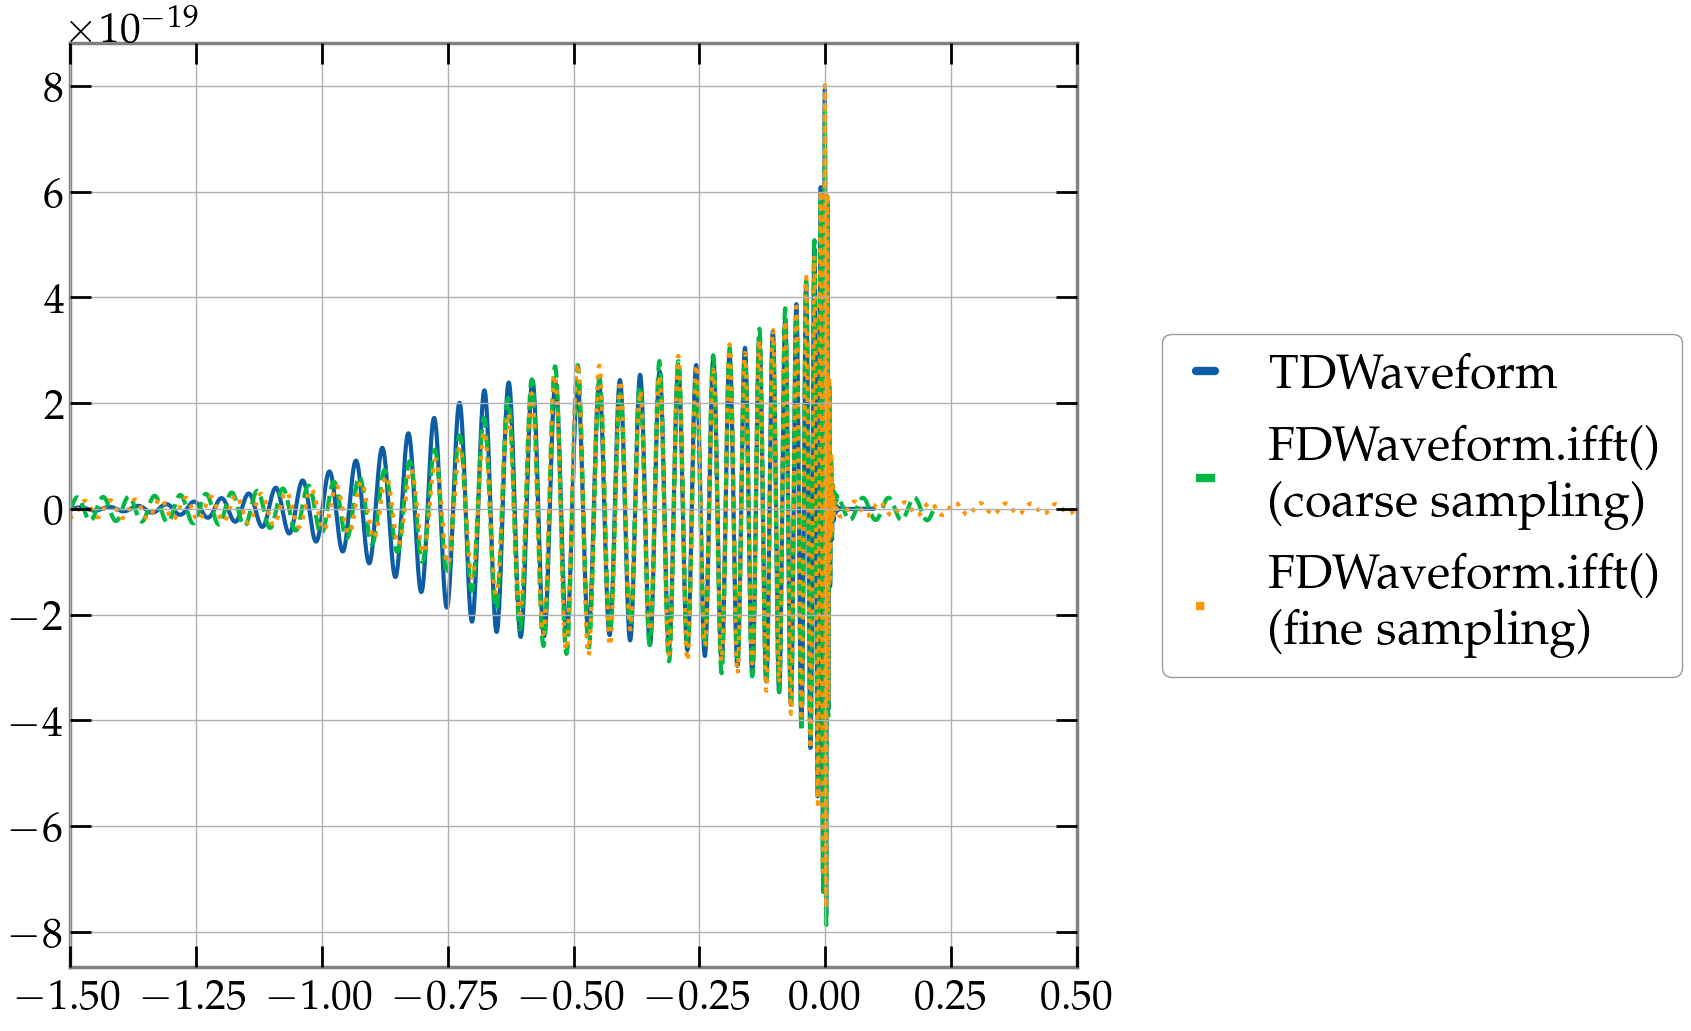

In [33]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_f_t_fine, ':', label='FDWaveform.ifft()\n(fine sampling)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-1.5, 0.5])

plt.show()

Close to merger, agreement has to be best

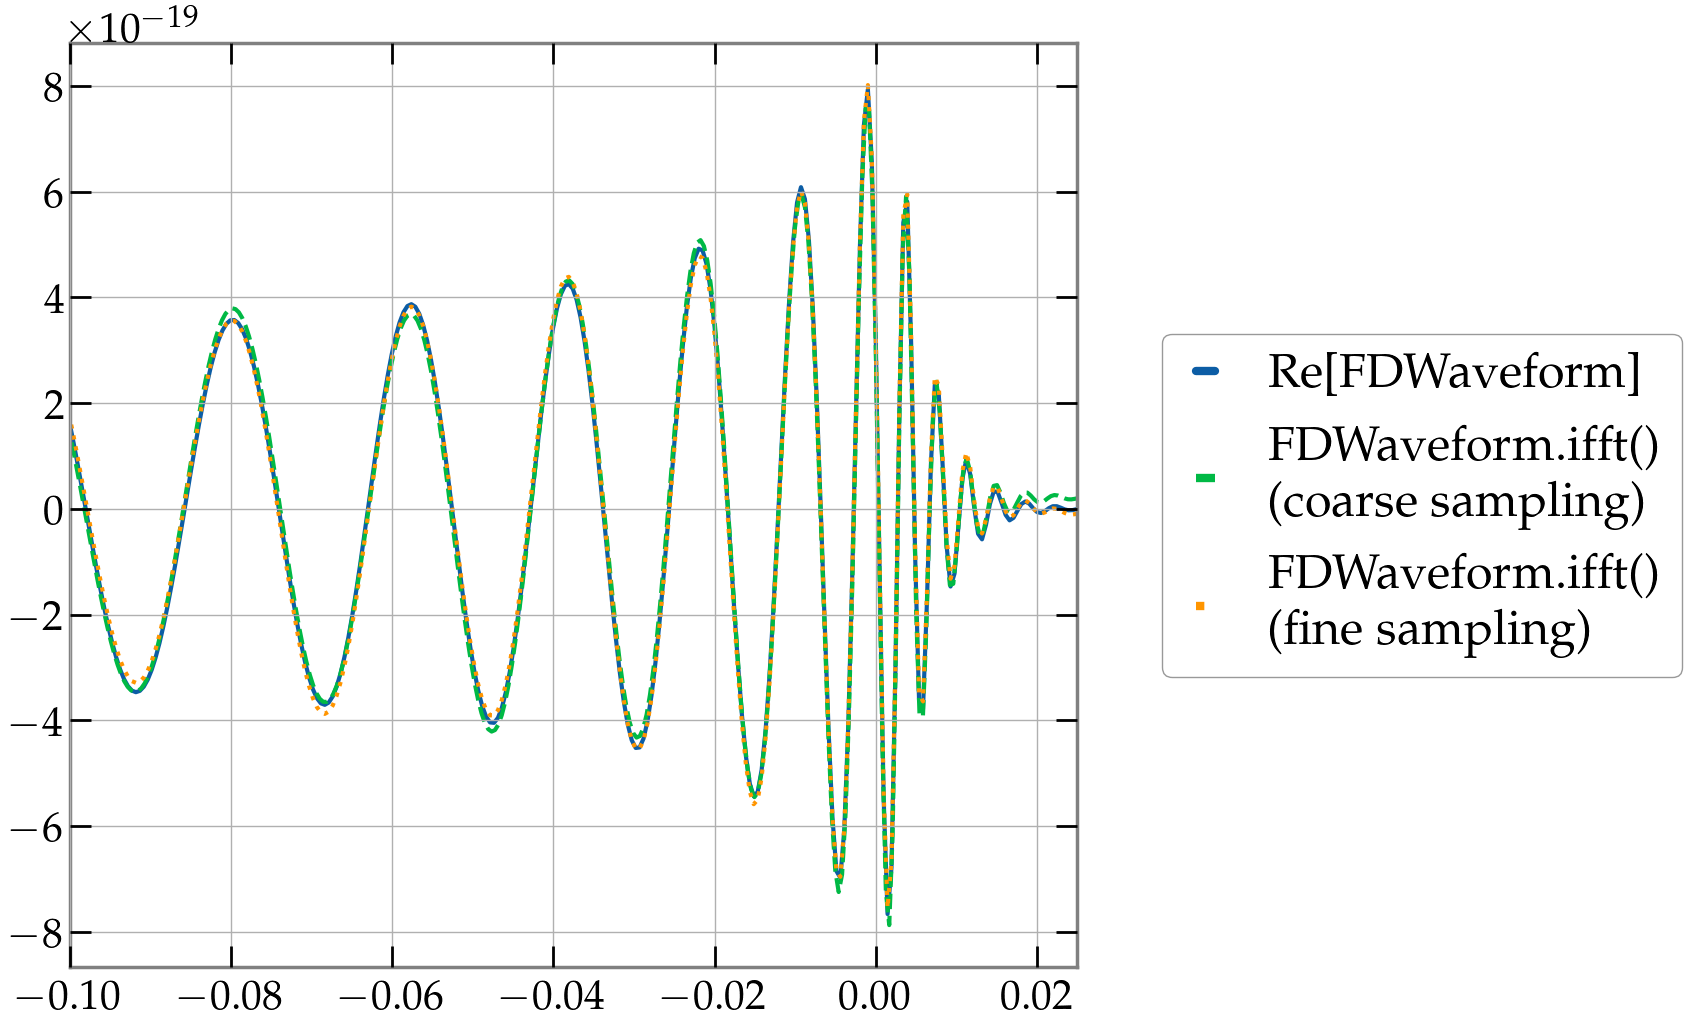

In [34]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='Re[FDWaveform]')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_f_t_fine, ':', label='FDWaveform.ifft()\n(fine sampling)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

# ax.set_xlim([-0.5, 0.05])
ax.set_xlim([-0.1, 0.025])

plt.show()

Differences between coarse and fine sampling remain, which makes sense. For fine sampling, the results are reasonably equal.

Most of the differences from the plot before are perhaps caused by tapering that we do not apply, but is applied for lal waveform

## Consistency of `get_strain` with manual generation and of rfft with fft

In [35]:
h_t = hp_t + 1.j * hc_t

h_f_fine = hp_f_fine + 1.j * hc_f_fine
h_f_coarse = hp_f_coarse + 1.j * hc_f_coarse

### `get_strain`

In [36]:
h_t_2 = get_strain(parameters_gw150914, 'time', generator=gen, mode='mixed')
h_t_f_coarse_2 = td_to_fd_waveform(h_t)
h_t_f_fine_2 = td_to_fd_waveform(pad_to_get_target_df(h_t, df=0.0625))

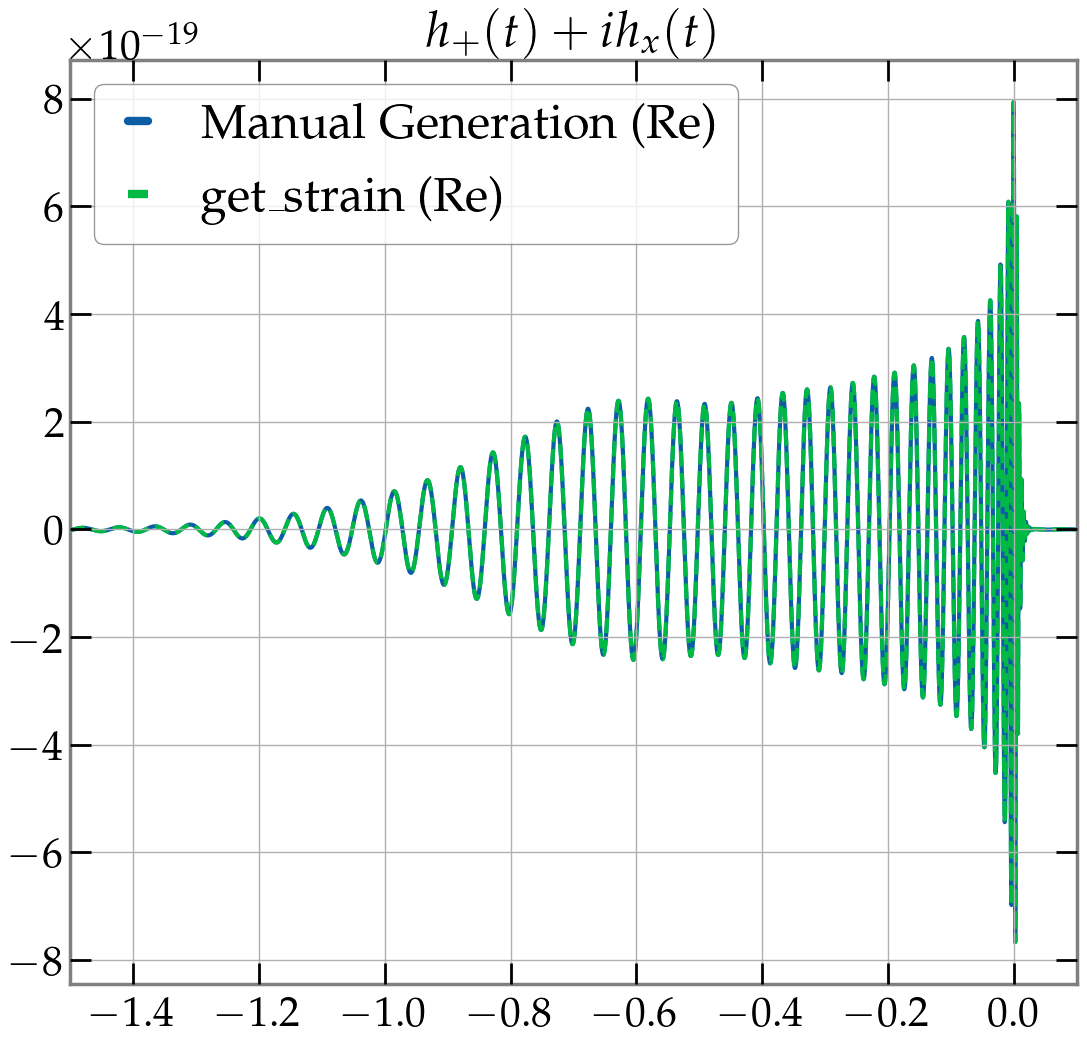

In [37]:
fig, ax = plt.subplots()

ax.plot(h_t.real, label='Manual Generation (Re)')
ax.plot(h_t_2.real, '--', label='get_strain (Re)')

# ax.plot(h_t.imag, label='Manual Generation (Im)')
# ax.plot(h_t_2.imag, '--', label='get_strain (Im)')

# ax.plot(h_t.abs(), label='Manual Generation (abs)')
# ax.plot(h_t_2.abs(), '--', label='get_strain (abs)')

ax.legend()
ax.set_title('$h_+(t) + i h_x(t)$')

ax.set_xlim([-1.5, 0.1])
# ax.set_xlim([-0.25, 0.01])

plt.show()

In [38]:
hp_f_fine_2 = get_strain(parameters_gw150914, 'frequency', generator=gen, mode='plus')
h_f_fine_2 = get_strain(parameters_gw150914, 'frequency', generator=gen, mode='mixed')

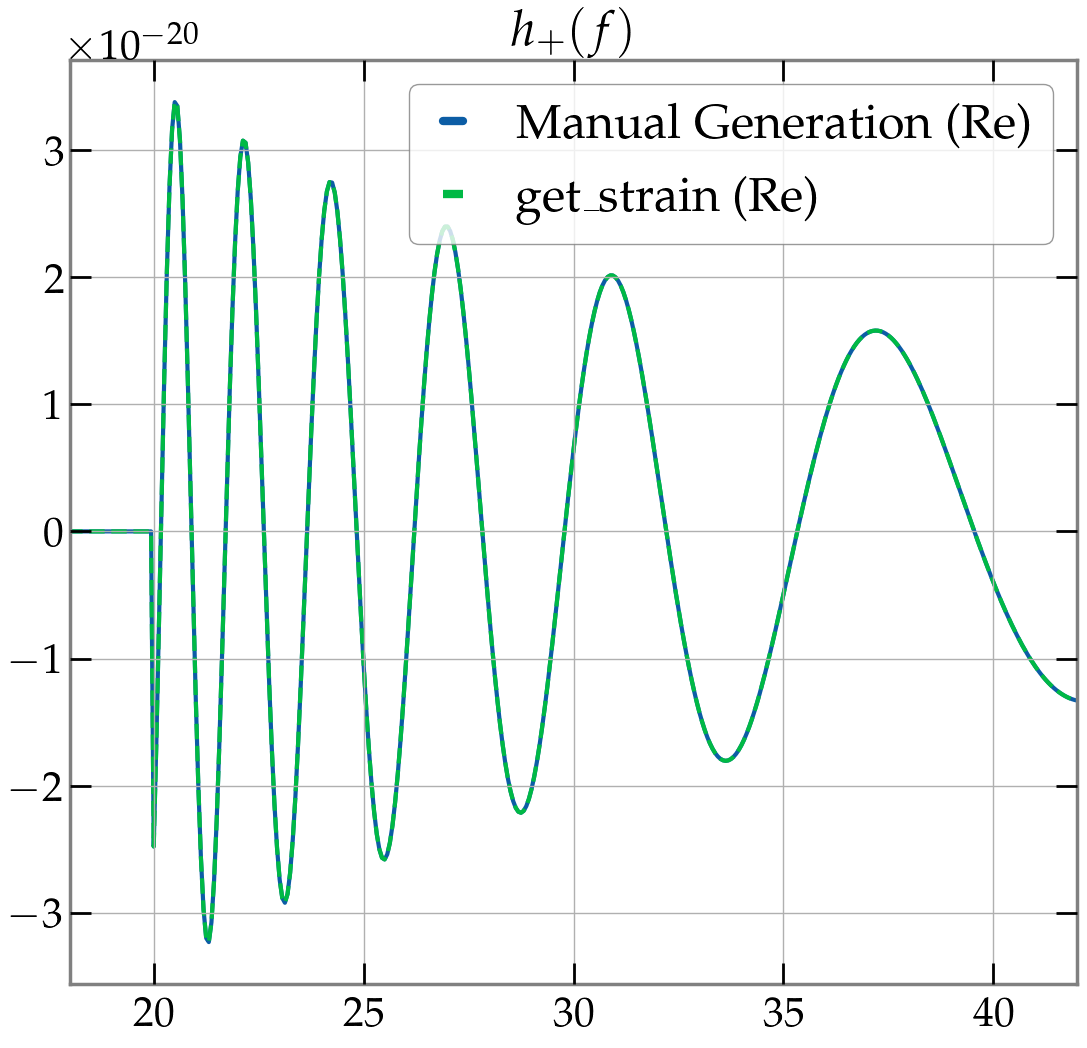

In [39]:
fig, ax = plt.subplots()

ax.plot(hp_f_fine.real, label='Manual Generation (Re)')
ax.plot(hp_f_fine_2.real, '--', label='get_strain (Re)')

# ax.plot(hp_f_fine.imag, label='Manual Generation (Im)')
# ax.plot(hp_f_fine_2.imag, '--', label='get_strain (Im)')

# ax.plot(hp_f_fine.abs(), label='Manual Generation (abs)')
# ax.plot(hp_f_fine_2.abs(), '--', label='get_strain (abs)')

ax.legend()
ax.set_title('$h_+(f)$')

ax.set_xlim([18, 42])
# ax.set_xlim([0, 60])

plt.show()

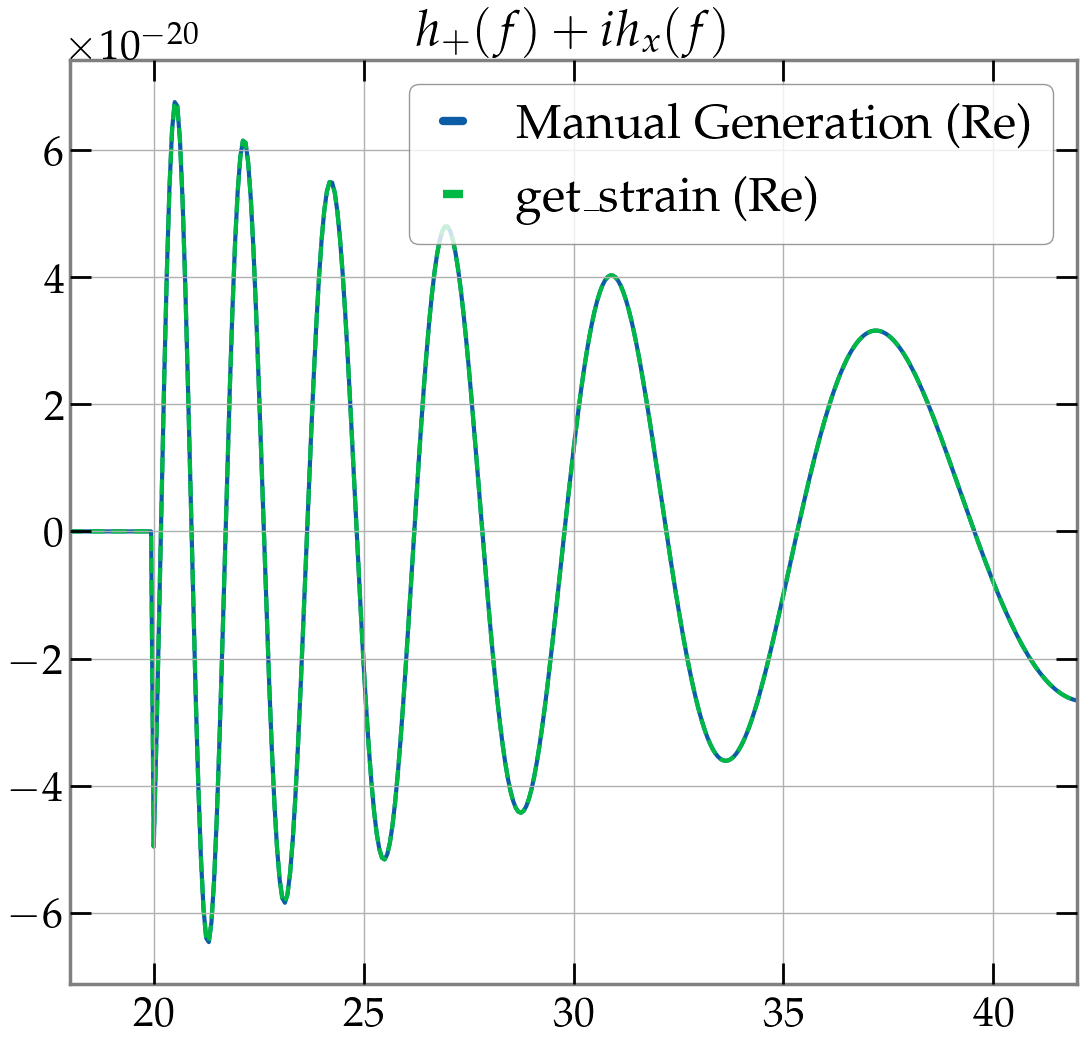

In [40]:
fig, ax = plt.subplots()

ax.plot(h_f_fine.real, label='Manual Generation (Re)')
ax.plot(h_f_fine_2.real, '--', label='get_strain (Re)')

# ax.plot(h_f_fine.imag, label='Manual Generation (Im)')
# ax.plot(h_f_fine_2.imag, '--', label='get_strain (Im)')

# ax.plot(h_f_fine.abs(), label='Manual Generation (abs)')
# ax.plot(h_f_fine_2.abs(), '--', label='get_strain (abs)')

ax.legend()
ax.set_title('$h_+(f) + i h_x(f)$')

ax.set_xlim([18, 42])
# ax.set_xlim([0, 60])

plt.show()

### rfft/fft

In [41]:
h_t_f_coarse = td_to_fd_waveform(h_t)
h_t_f_fine = td_to_fd_waveform(pad_to_get_target_df(h_t, df=0.0625))

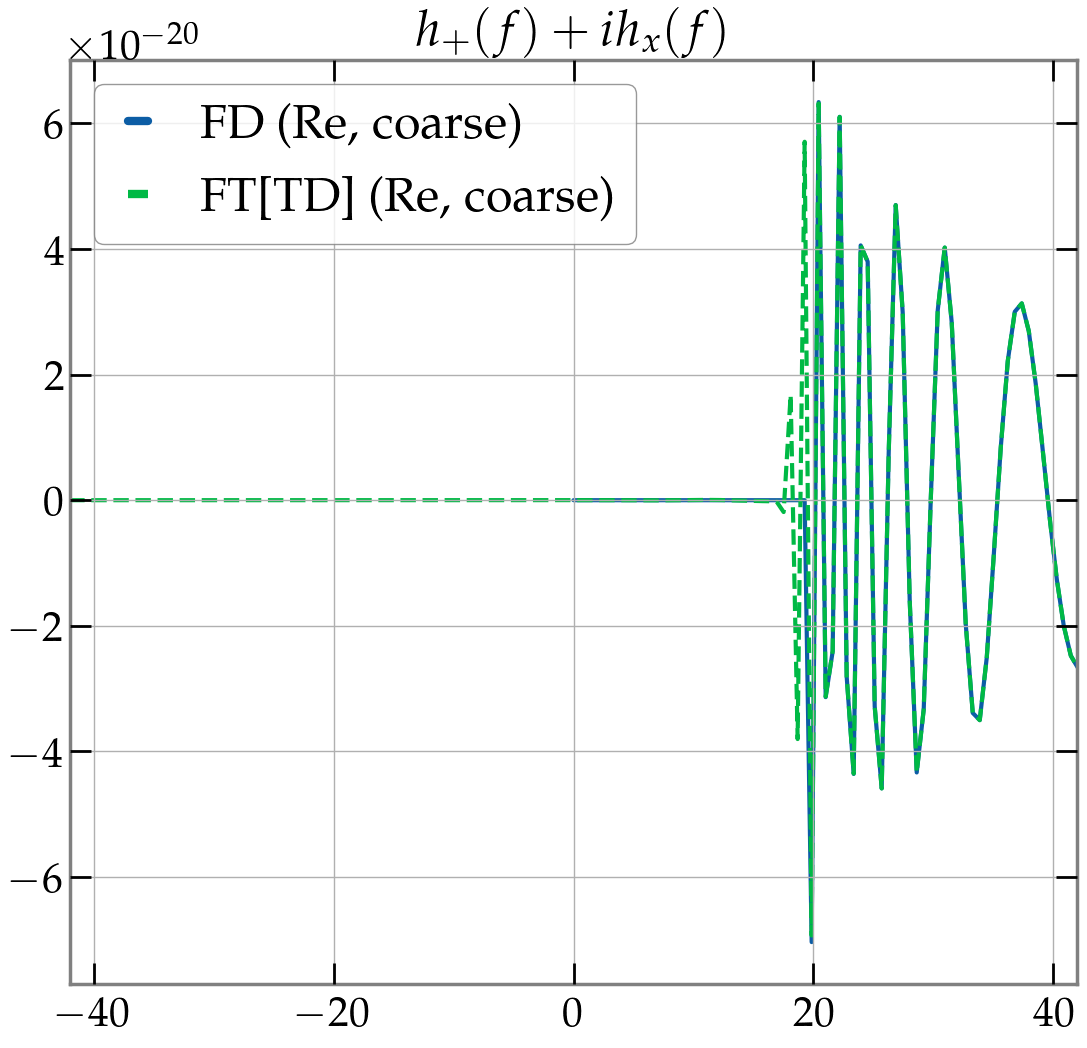

In [42]:
fig, ax = plt.subplots()

ax.plot(h_f_coarse.real, label='FD (Re, coarse)')
ax.plot(h_t_f_coarse.real, '--', label='FT[TD] (Re, coarse)')

# ax.plot(h_f_coarse.imag, label='FD (Im, coarse)')
# ax.plot(h_t_f_coarse.imag, '--', label='FT[TD] (Im, coarse)')

# ax.plot(h_f_coarse.abs(), label='FD (abs, coarse)')
# ax.plot(h_t_f_coarse.abs(), '--', label='FT[TD] (abs, coarse)')

ax.legend()
ax.set_title('$h_+(f) + i h_x(f)$')

# ax.set_xlim([0, 42])
ax.set_xlim([-42, 42])

plt.show()

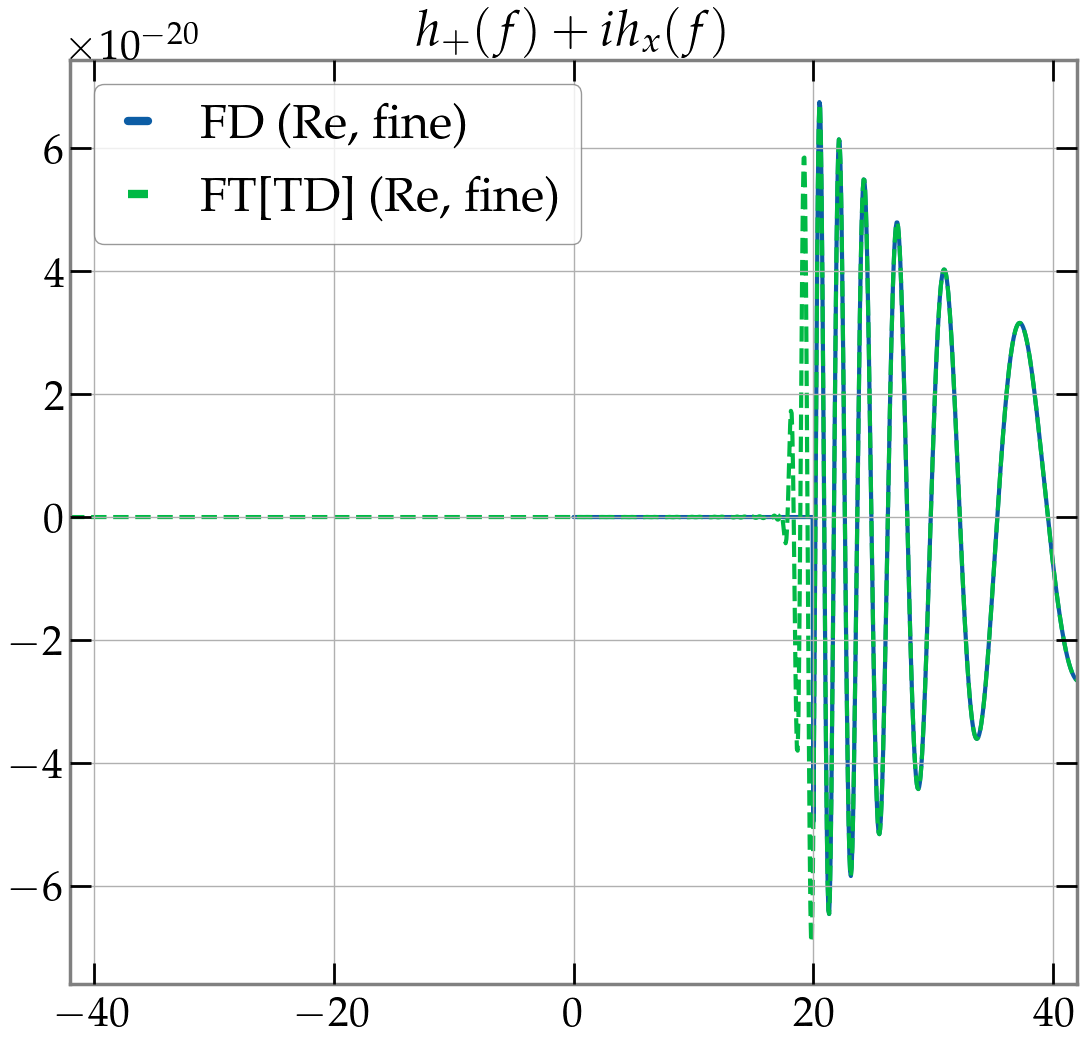

In [43]:
fig, ax = plt.subplots()

ax.plot(h_f_fine.real, label='FD (Re, fine)')
ax.plot(h_t_f_fine.real, '--', label='FT[TD] (Re, fine)')

# ax.plot(h_f_fine.imag, label='FD (Im, fine)')
# ax.plot(h_t_f_fine.imag, '--', label='FT[TD] (Im, fine)')

# ax.plot(h_f_fine.abs(), label='FD (abs, fine)')
# ax.plot(h_t_f_fine.abs(), '--', label='FT[TD] (abs, fine)')

ax.legend()
ax.set_title('$h_+(f) + i h_x(f)$')

# ax.set_xlim([0, 42])
ax.set_xlim([-42, 42])

plt.show()

Now we show that using the rfft is justified. We do that by adding an vanishing imaginary part to $h_+$ (which still converts the type to complex).

In [44]:
hp_t_complex = hp_t + 1.j * 0.0

hp_t_complex_f_coarse = td_to_fd_waveform(hp_t_complex)
hp_t_complex_f_fine = td_to_fd_waveform(pad_to_get_target_df(hp_t_complex, df=0.0625))

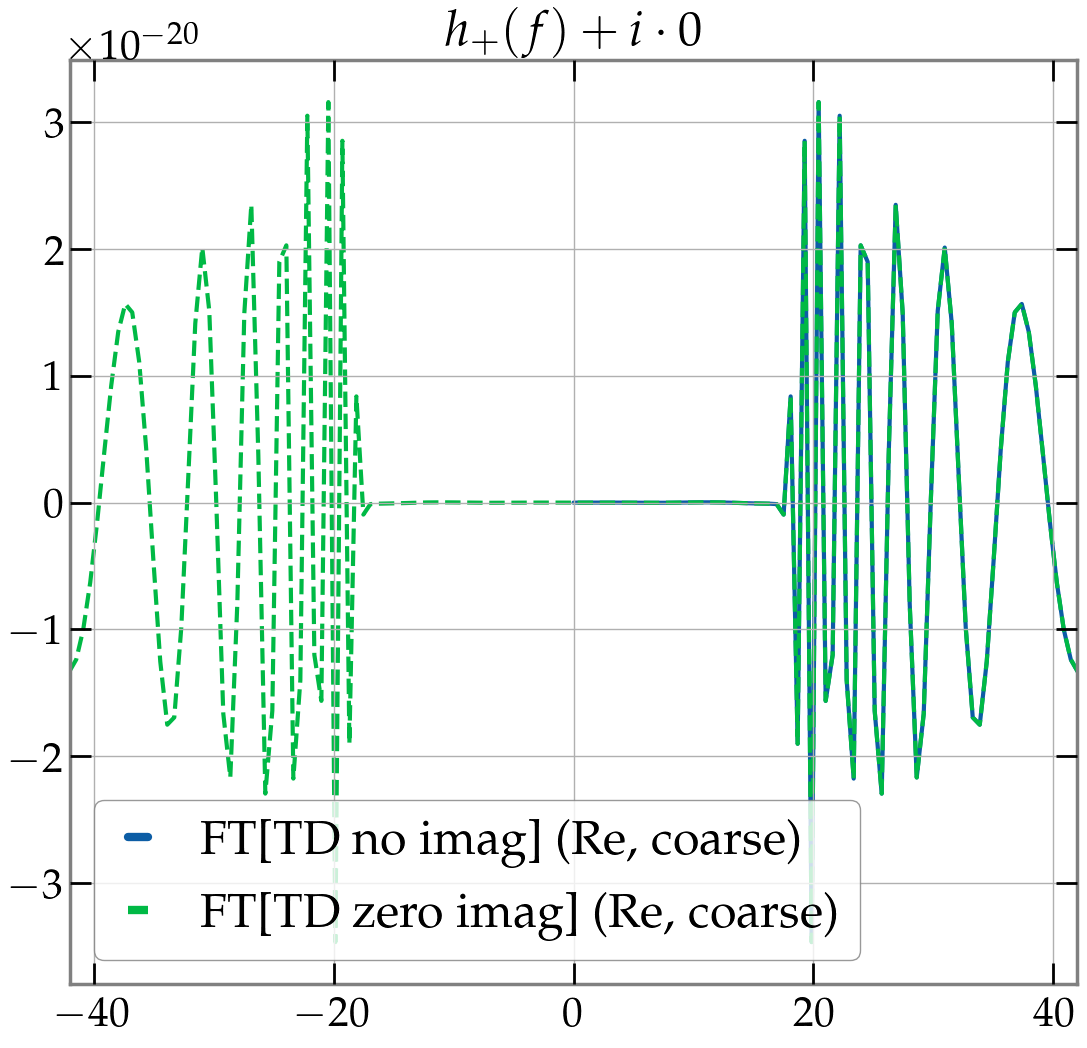

In [45]:
fig, ax = plt.subplots()

ax.plot(hp_t_f_coarse.real, label='FT[TD no imag] (Re, coarse)')
ax.plot(hp_t_complex_f_coarse.real, '--', label='FT[TD zero imag] (Re, coarse)')

# ax.plot(hp_t_f_coarse.imag, label='FT[TD no imag] (Im, coarse)')
# ax.plot(hp_t_complex_f_coarse.imag, '--', label='FT[TD zero imag] (Im, coarse)')

# ax.plot(hp_t_f_coarse.abs(), label='FT[TD no imag] (abs, coarse)')
# ax.plot(hp_t_complex_f_coarse.abs(), '--', label='FT[TD zero imag] (abs, coarse)')

ax.legend()
ax.set_title('$h_+(f) + i \cdot 0$')

# ax.set_xlim([0, 42])
ax.set_xlim([-42, 42])

plt.show()

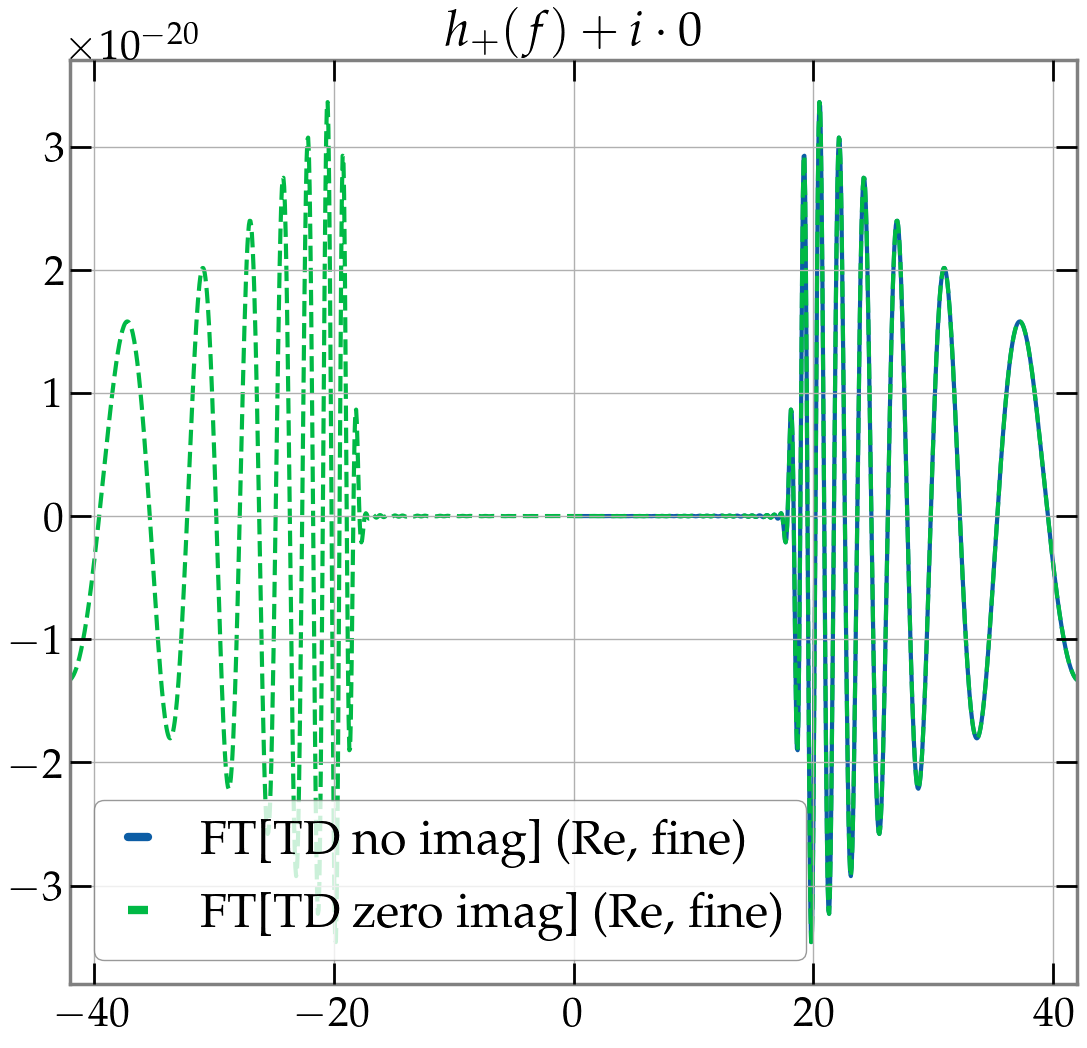

In [46]:
fig, ax = plt.subplots()

ax.plot(hp_t_f_fine.real, label='FT[TD no imag] (Re, fine)')
ax.plot(hp_t_complex_f_fine.real, '--', label='FT[TD zero imag] (Re, fine)')

# ax.plot(hp_t_f_fine.imag, label='FT[TD no imag] (Im, fine)')
# ax.plot(hp_t_complex_f_fine.imag, '--', label='FT[TD zero imag] (Im, fine)')

# ax.plot(hp_t_f_fine.abs(), label='FT[TD no imag] (abs, fine)')
# ax.plot(hp_t_complex_f_fine.abs(), '--', label='FT[TD zero imag] (abs, fine)')

ax.legend()
ax.set_title('$h_+(f) + i \cdot 0$')

# ax.set_xlim([0, 42])
ax.set_xlim([-42, 42])

plt.show()

## Impact of Tapering

To be examined

Hypothesis: causes slight differences of signals coming out of generator and signals in other domain that are converted using our procedures (tapering changes Fourier components slightly, also morphology in time domain)

## Impact of Filtering

### In Frequency Domain

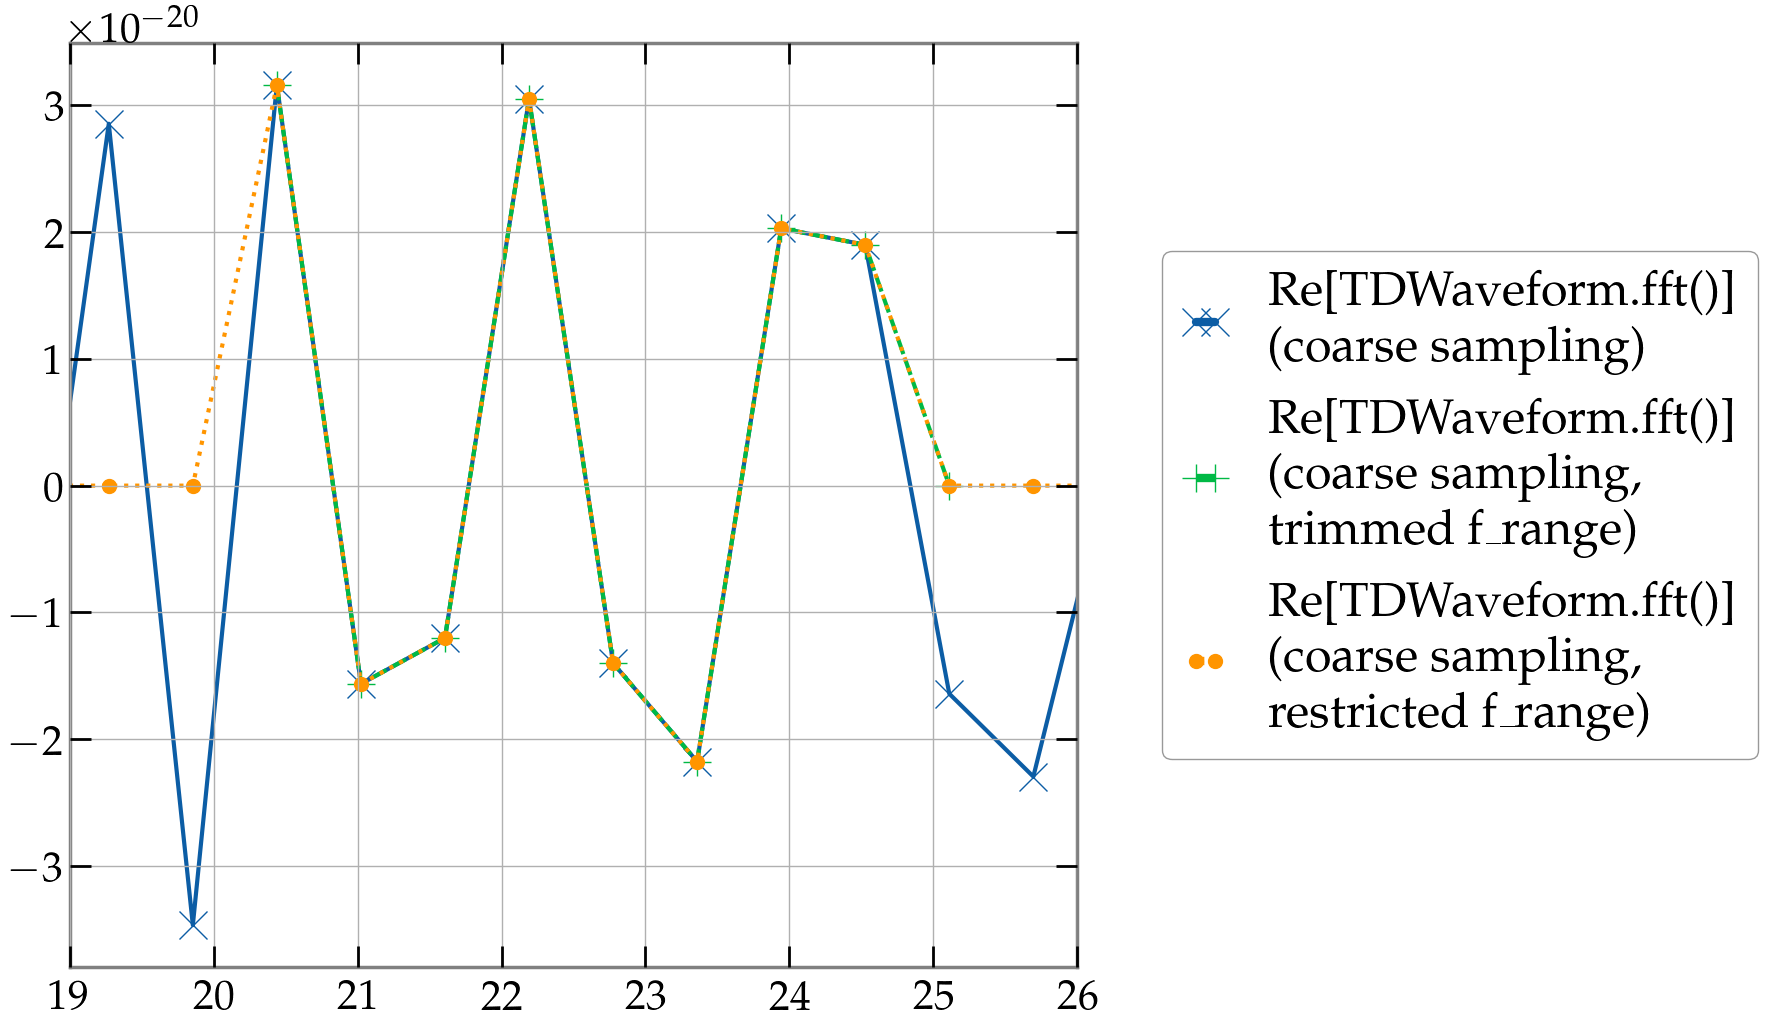

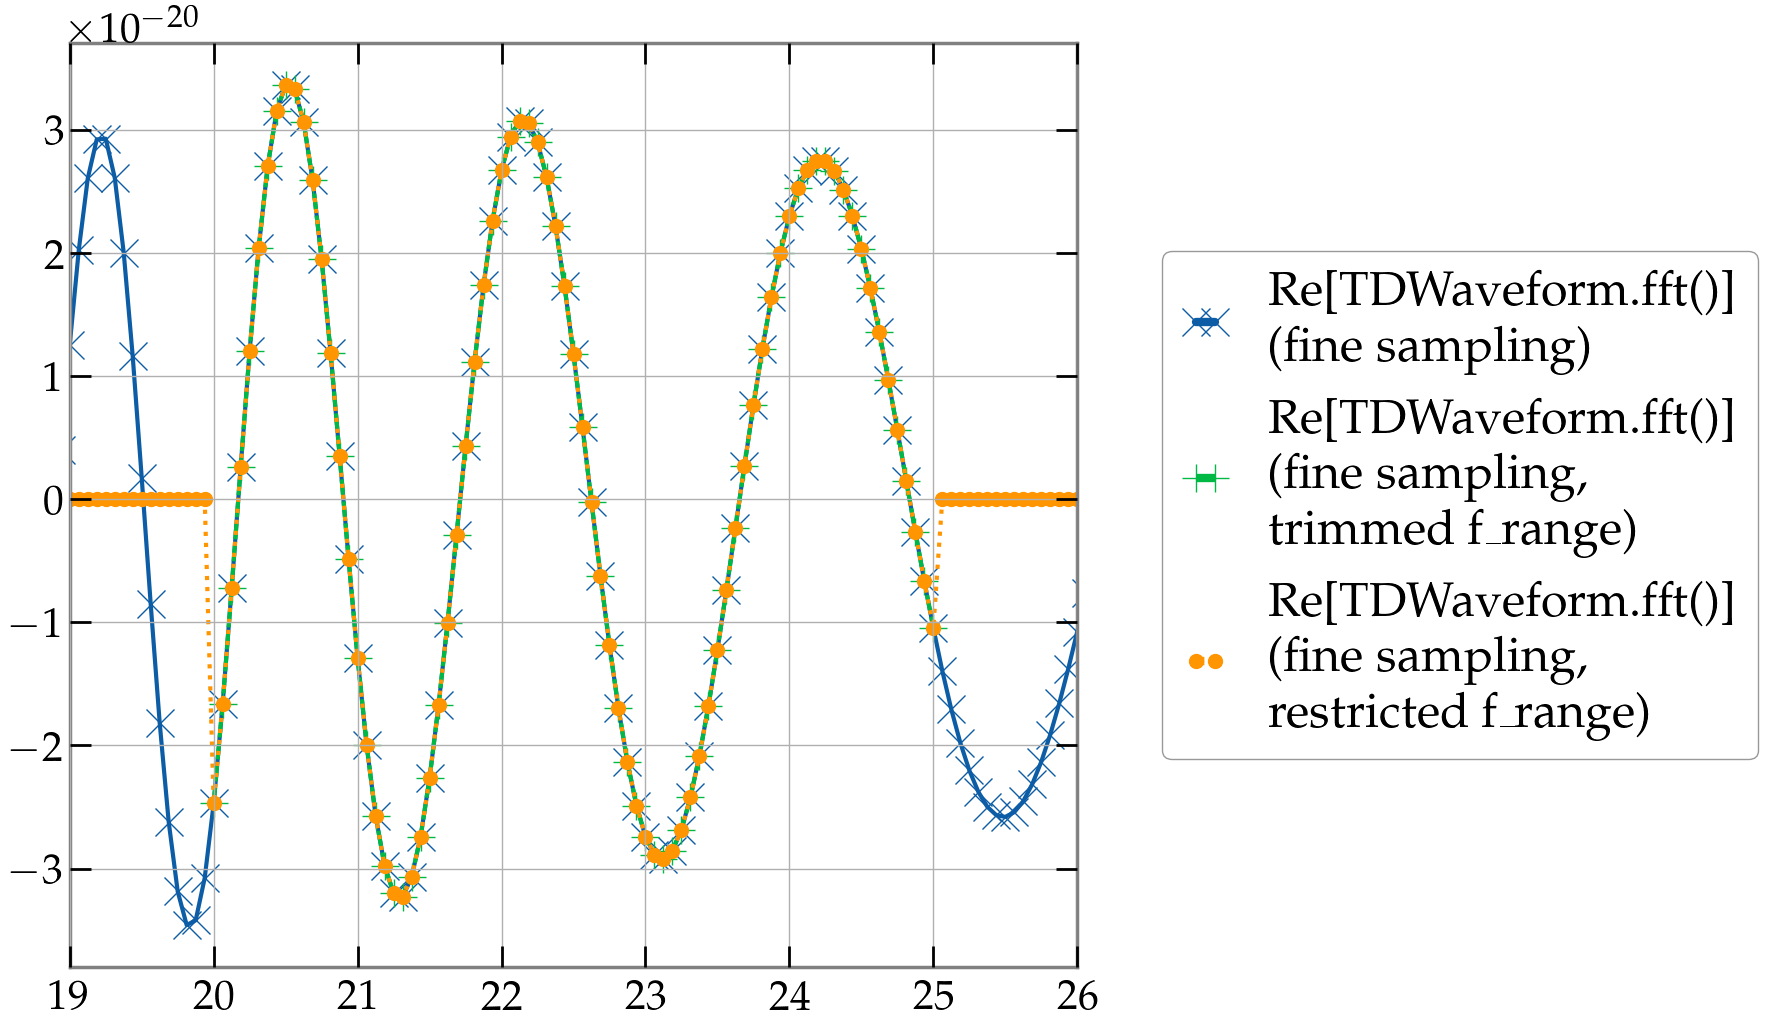

In [47]:
fig,ax = plt.subplots()

ax.plot(hp_t_f_coarse.real, 'x-', label='Re[TDWaveform.fft()]\n(coarse sampling)')

ax.plot(restrict_f_range(hp_t_f_coarse, f_range=[20, 25]).real, '+--', label='Re[TDWaveform.fft()]\n(coarse sampling,\ntrimmed f_range)')

ax.plot(restrict_f_range(hp_t_f_coarse, fill_range=[20, 25]).real, '.:', label='Re[TDWaveform.fft()]\n(coarse sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])
ax.set_xlim([19.0, 26])

plt.show()


fig,ax = plt.subplots()

ax.plot(hp_t_f_fine.real, 'x-', label='Re[TDWaveform.fft()]\n(fine sampling)')

ax.plot(restrict_f_range(hp_t_f_fine, f_range=[20, 25]).real, '+--', label='Re[TDWaveform.fft()]\n(fine sampling,\ntrimmed f_range)')

ax.plot(restrict_f_range(hp_t_f_fine, fill_range=[20, 25]).real, '.:', label='Re[TDWaveform.fft()]\n(fine sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])
ax.set_xlim([19.0, 26.0])
# ax.set_xlim([19.9, 20.1])

plt.show()

Does exactly what it should do: setting frequency components out of range to zero while leaving other samples untouched

Now testing what happens with upper_cut=True, if it has same range as setting to zero

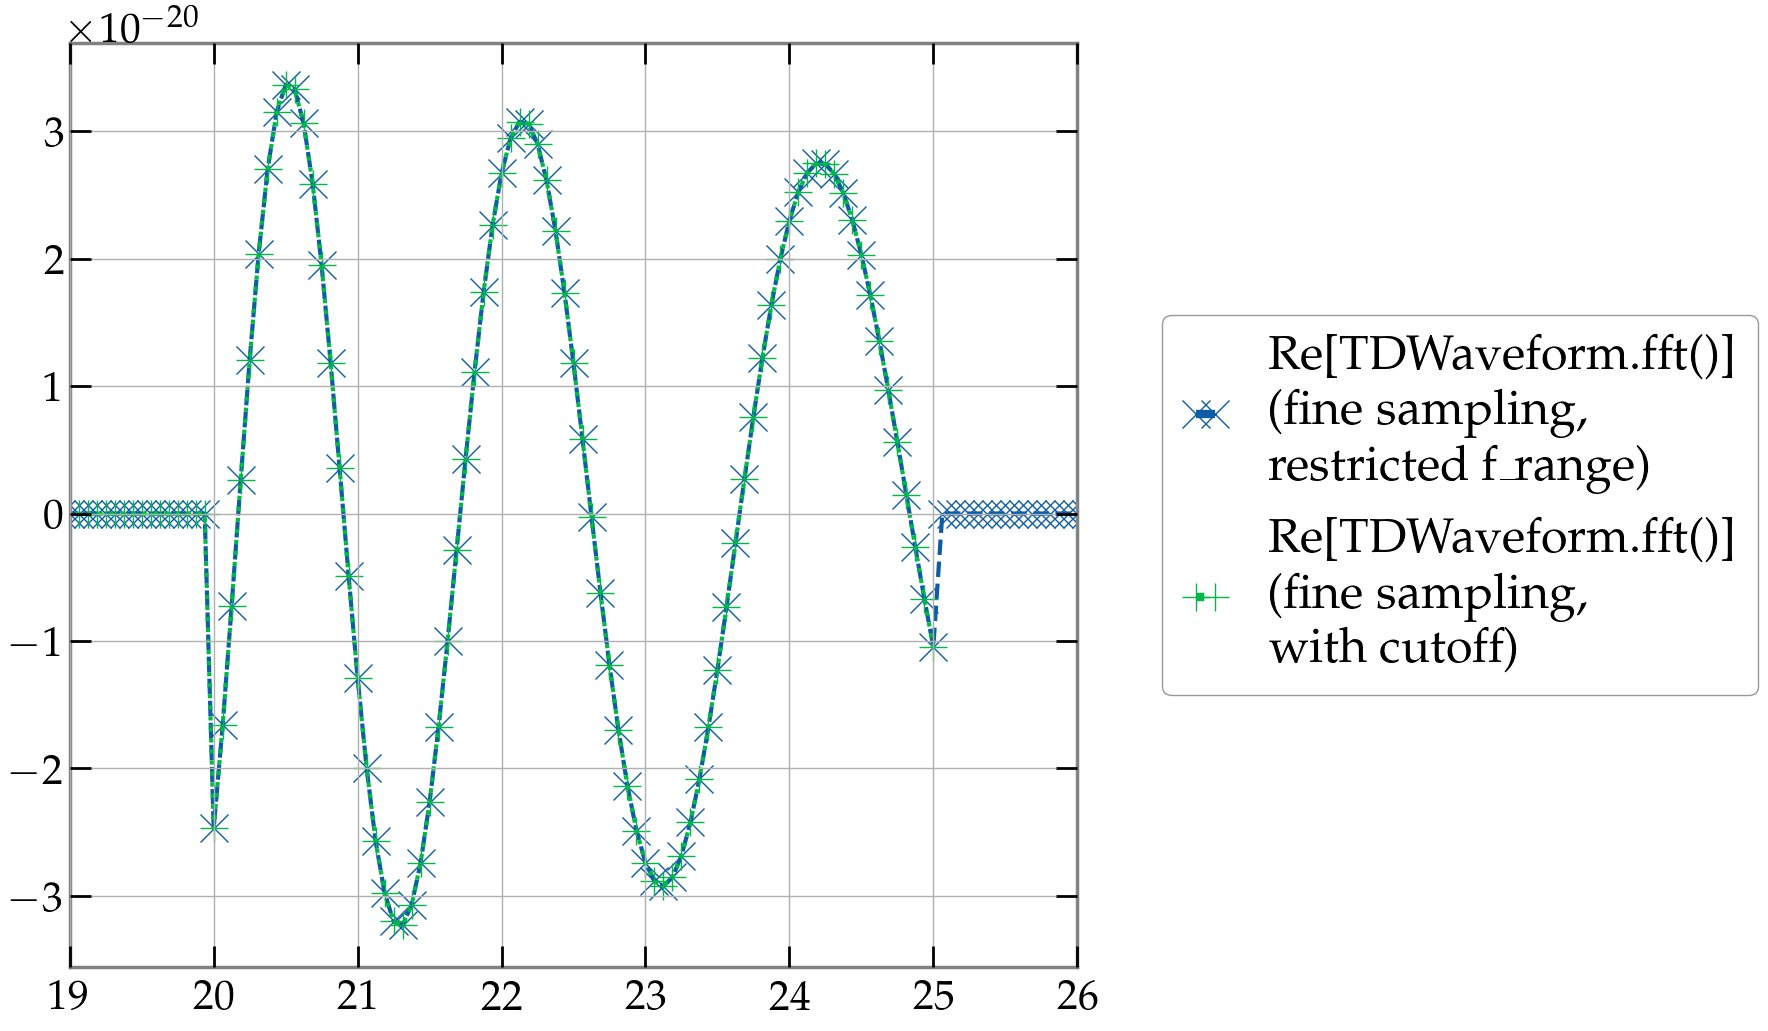

In [48]:
fig,ax = plt.subplots()

ax.plot(restrict_f_range(hp_t_f_fine, fill_range=[20, 25]).real, 'x--', label='Re[TDWaveform.fft()]\n(fine sampling,\nrestricted f_range)')

ax.plot(restrict_f_range(hp_t_f_fine, f_range=[None, 25], fill_range=[20, None]).real, '+:', label='Re[TDWaveform.fft()]\n(fine sampling,\nwith cutoff)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])
ax.set_xlim([19.0, 26.0])
# ax.set_xlim([19.9, 20.1])

plt.show()

### In Time Domain

In [49]:
hp_t_coarse_filtered = fd_to_td_waveform(restrict_f_range(hp_t_f_coarse, fill_range=[f_min, None]))
hp_t_fine_filtered = fd_to_td_waveform(restrict_f_range(hp_t_f_fine, fill_range=[f_min, None]))

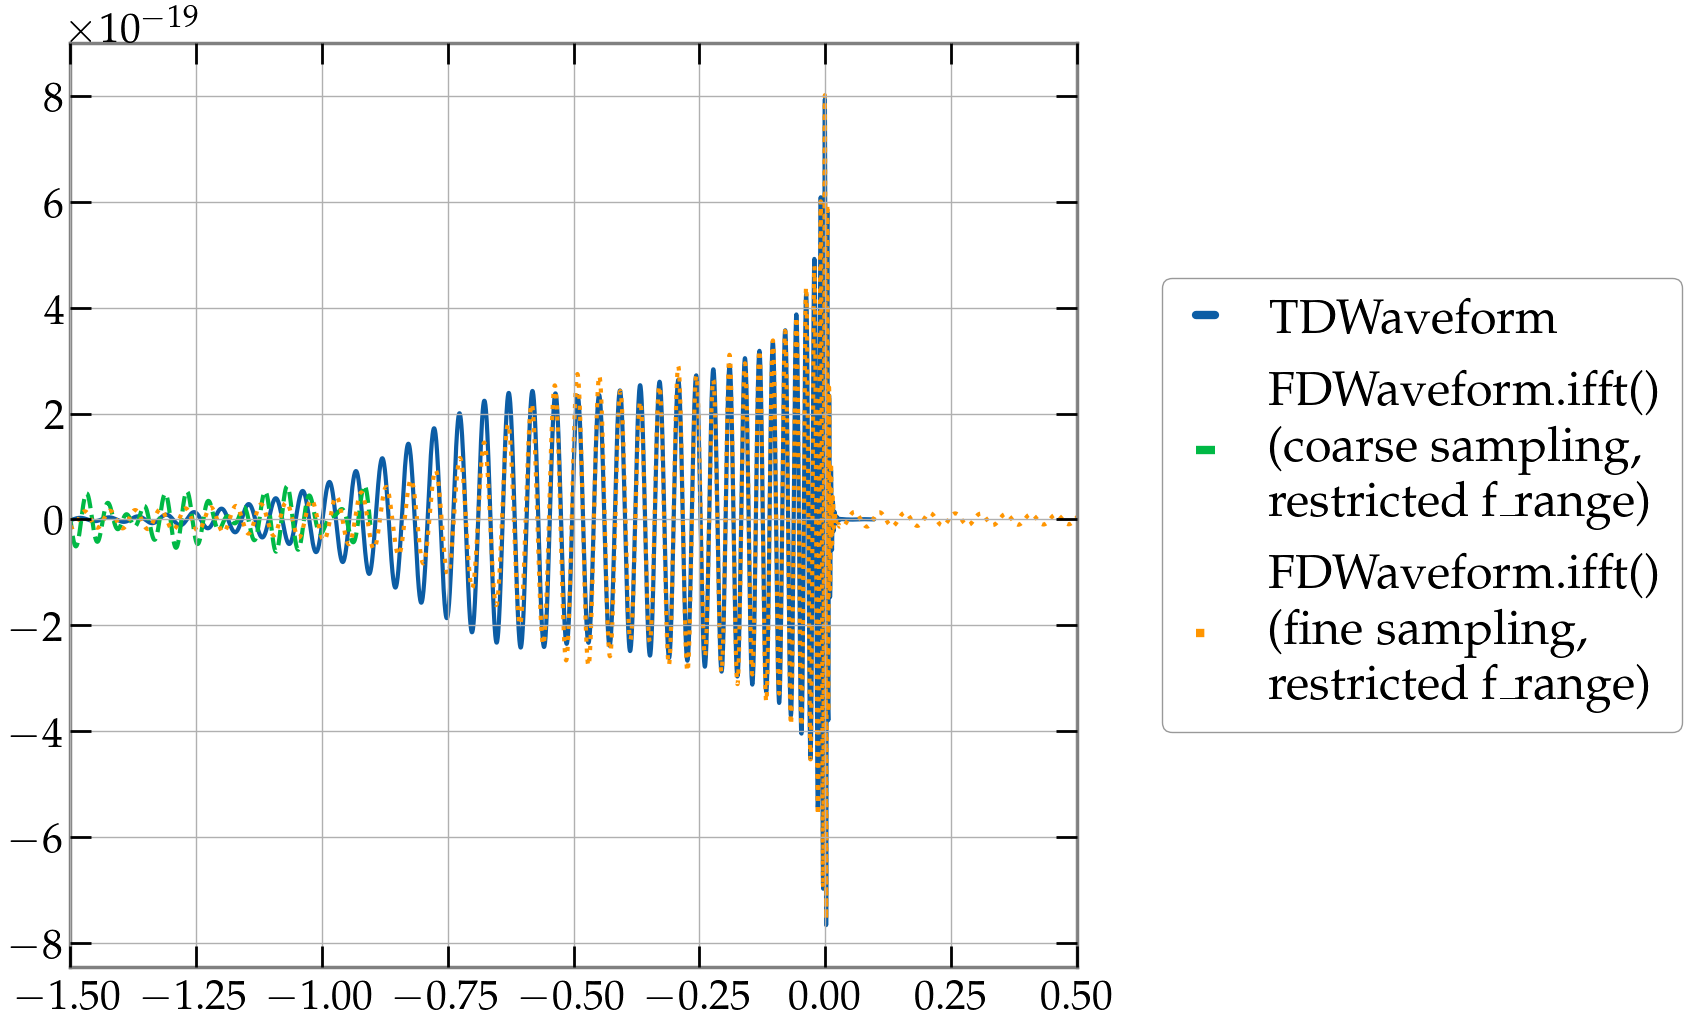

In [50]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_coarse_filtered, '--', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend()
ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-1.5, 0.5])

plt.show()

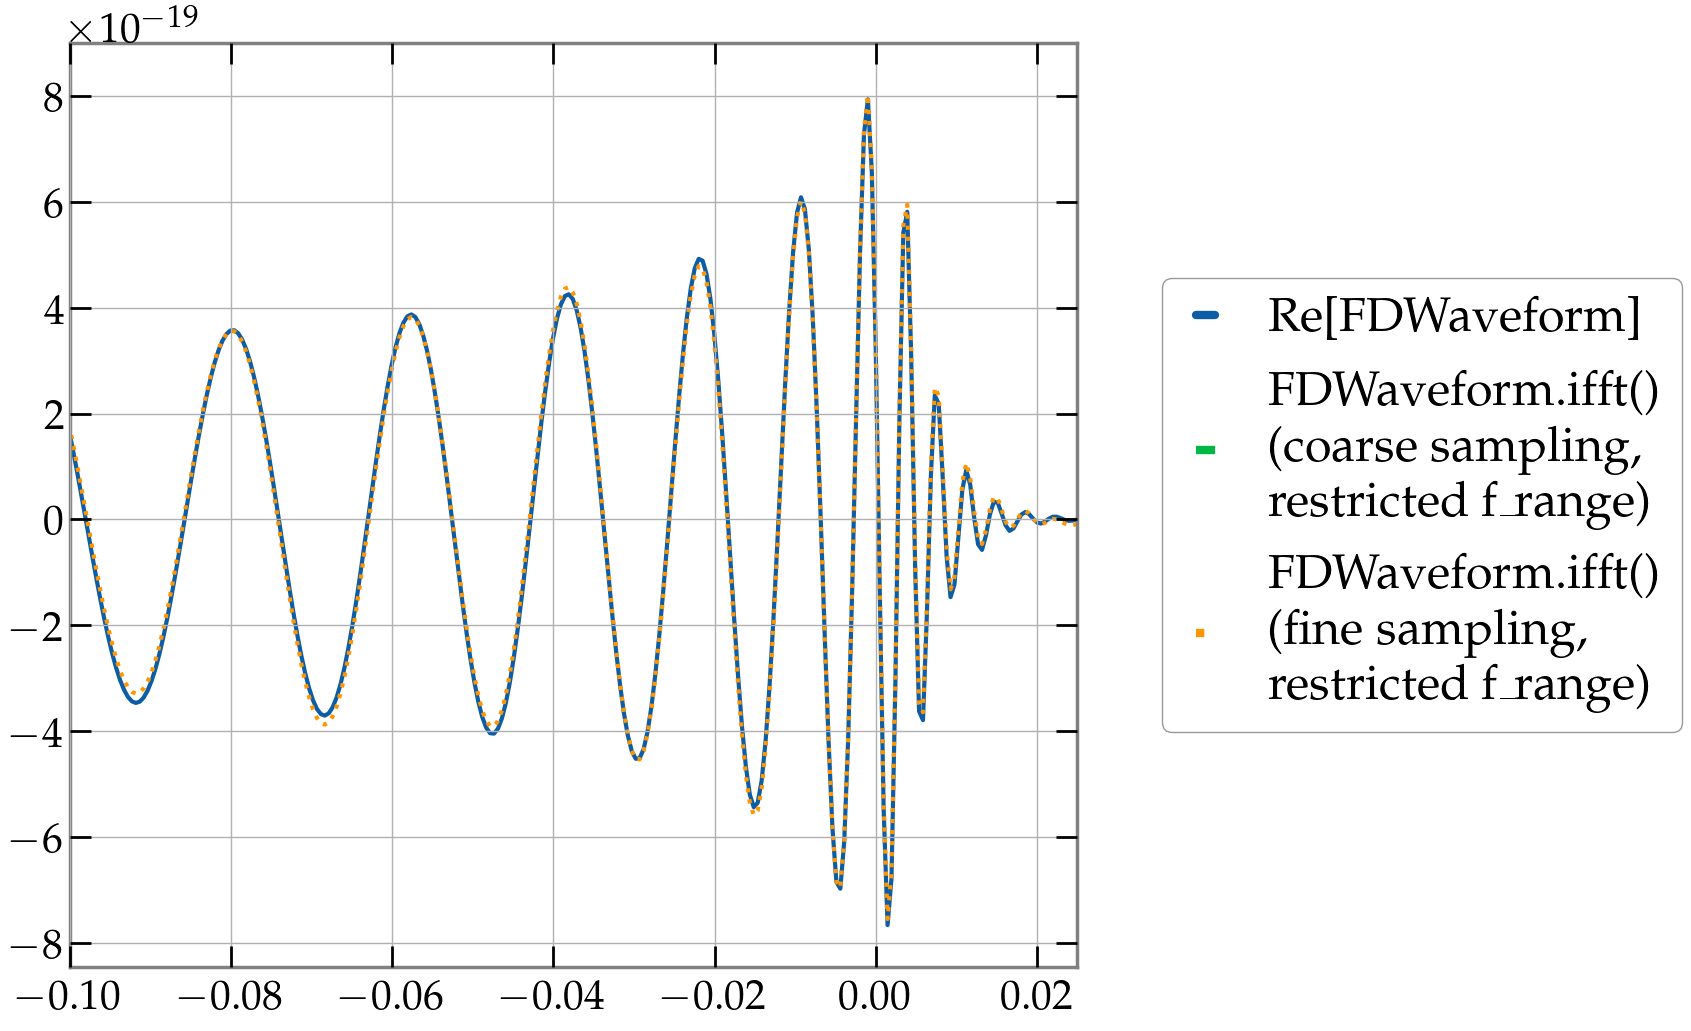

In [51]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='Re[FDWaveform]')

ax.plot(hp_t_coarse_filtered, '--', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-0.1, 0.025])

plt.show()

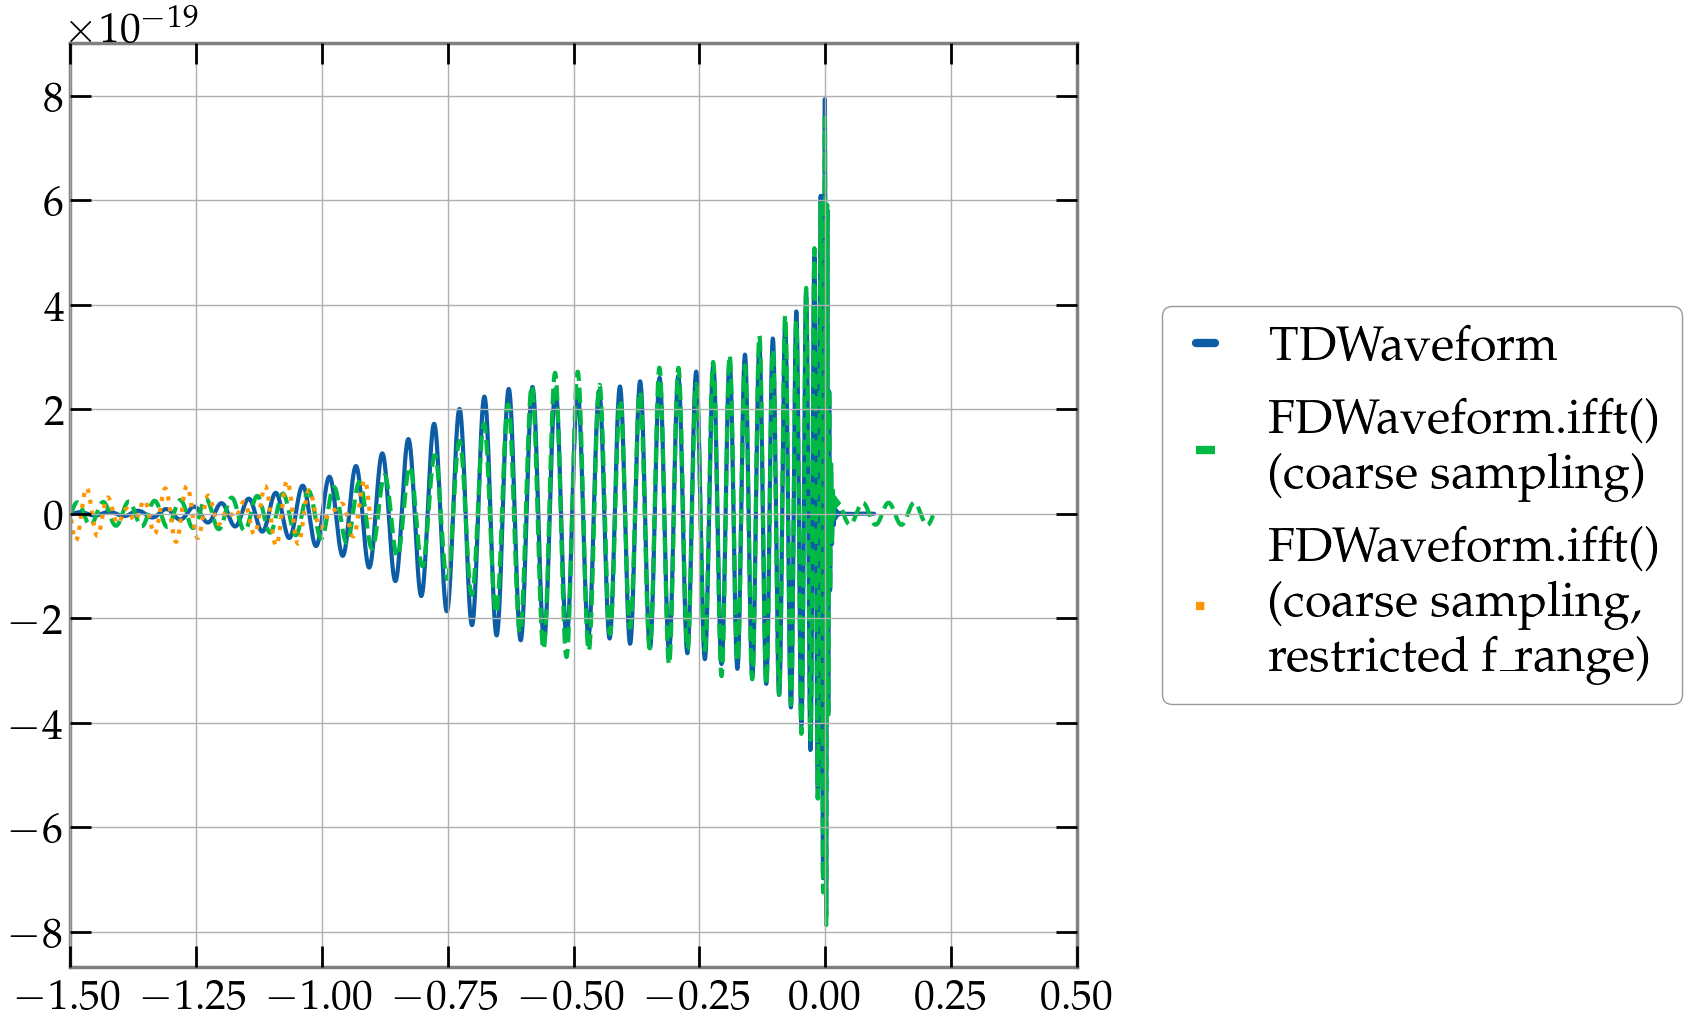

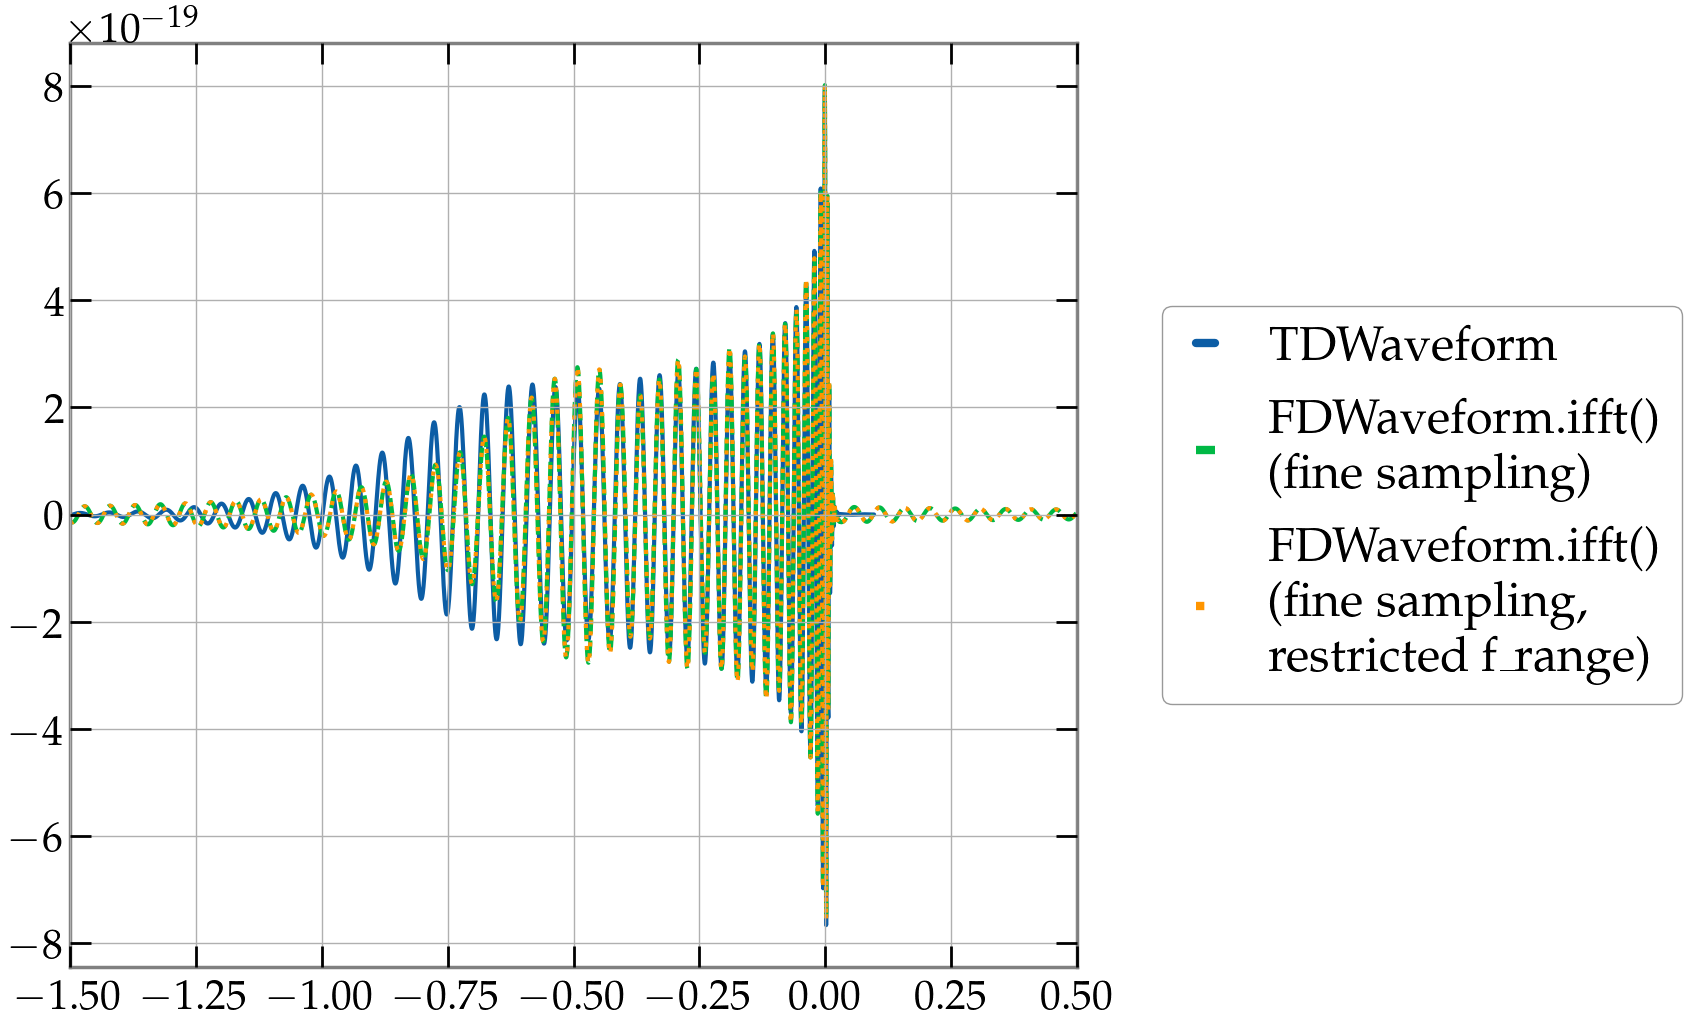

In [52]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_t_coarse_filtered, ':', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-1.5, 0.5])

plt.show()



fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_fine, '--', label='FDWaveform.ifft()\n(fine sampling)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-1.5, 0.5])

plt.show()

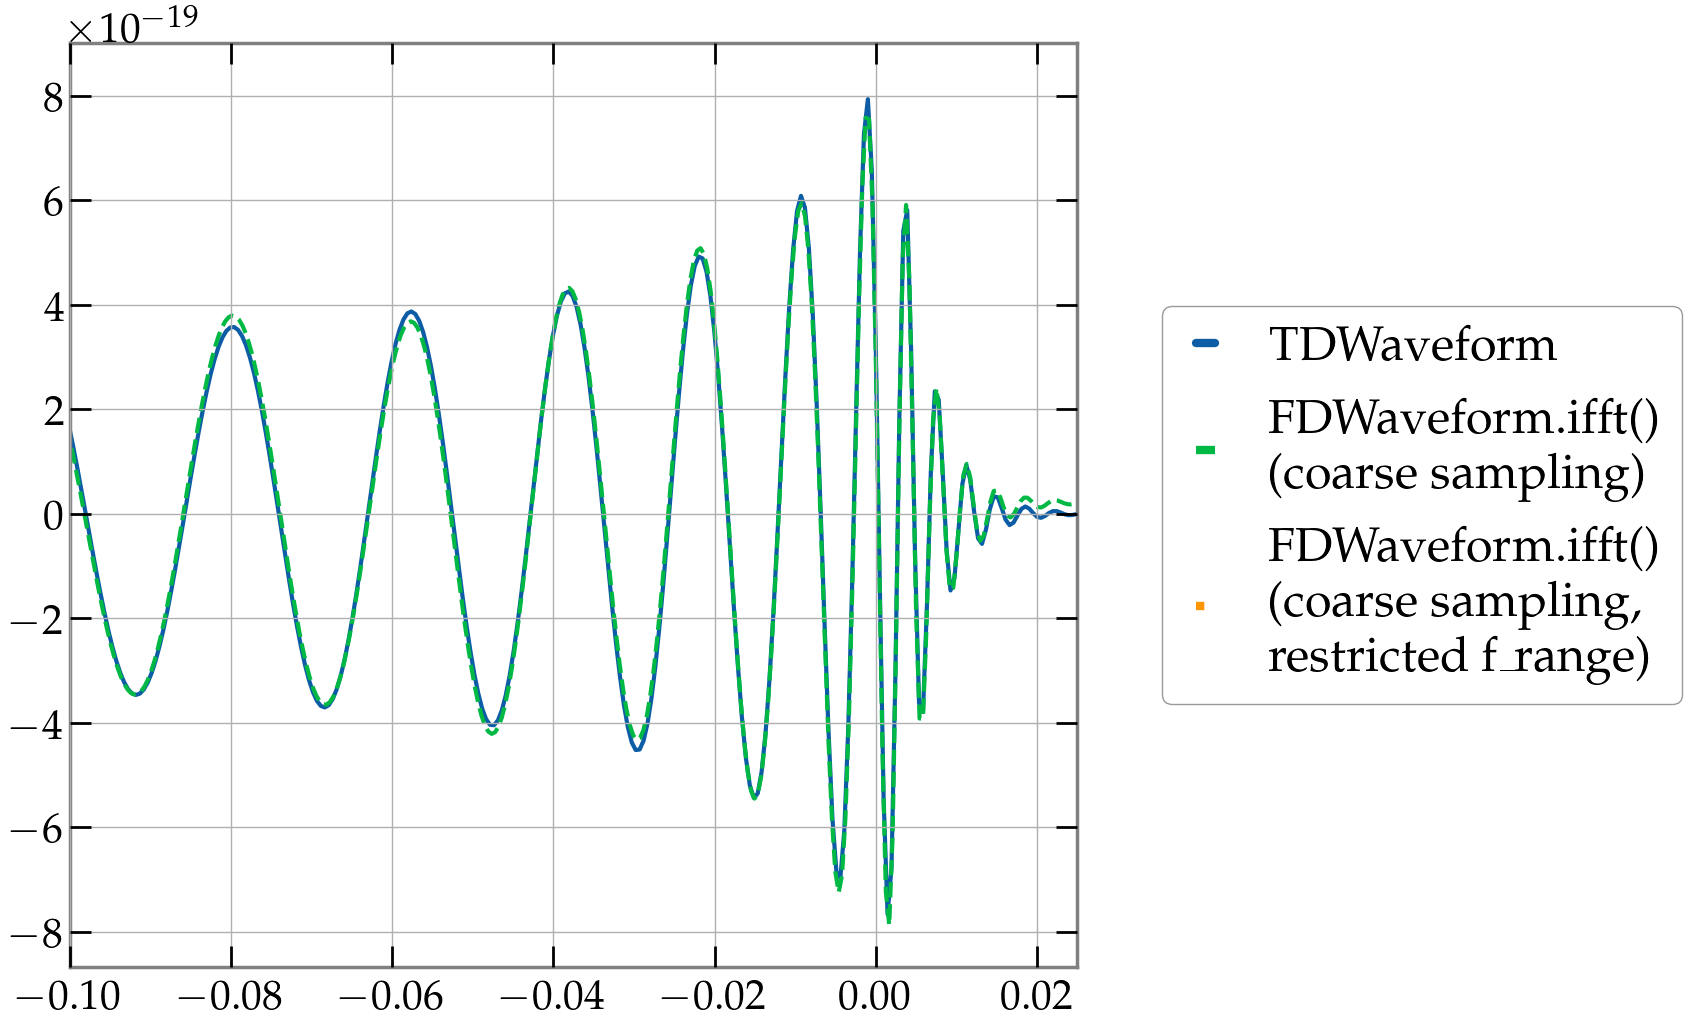

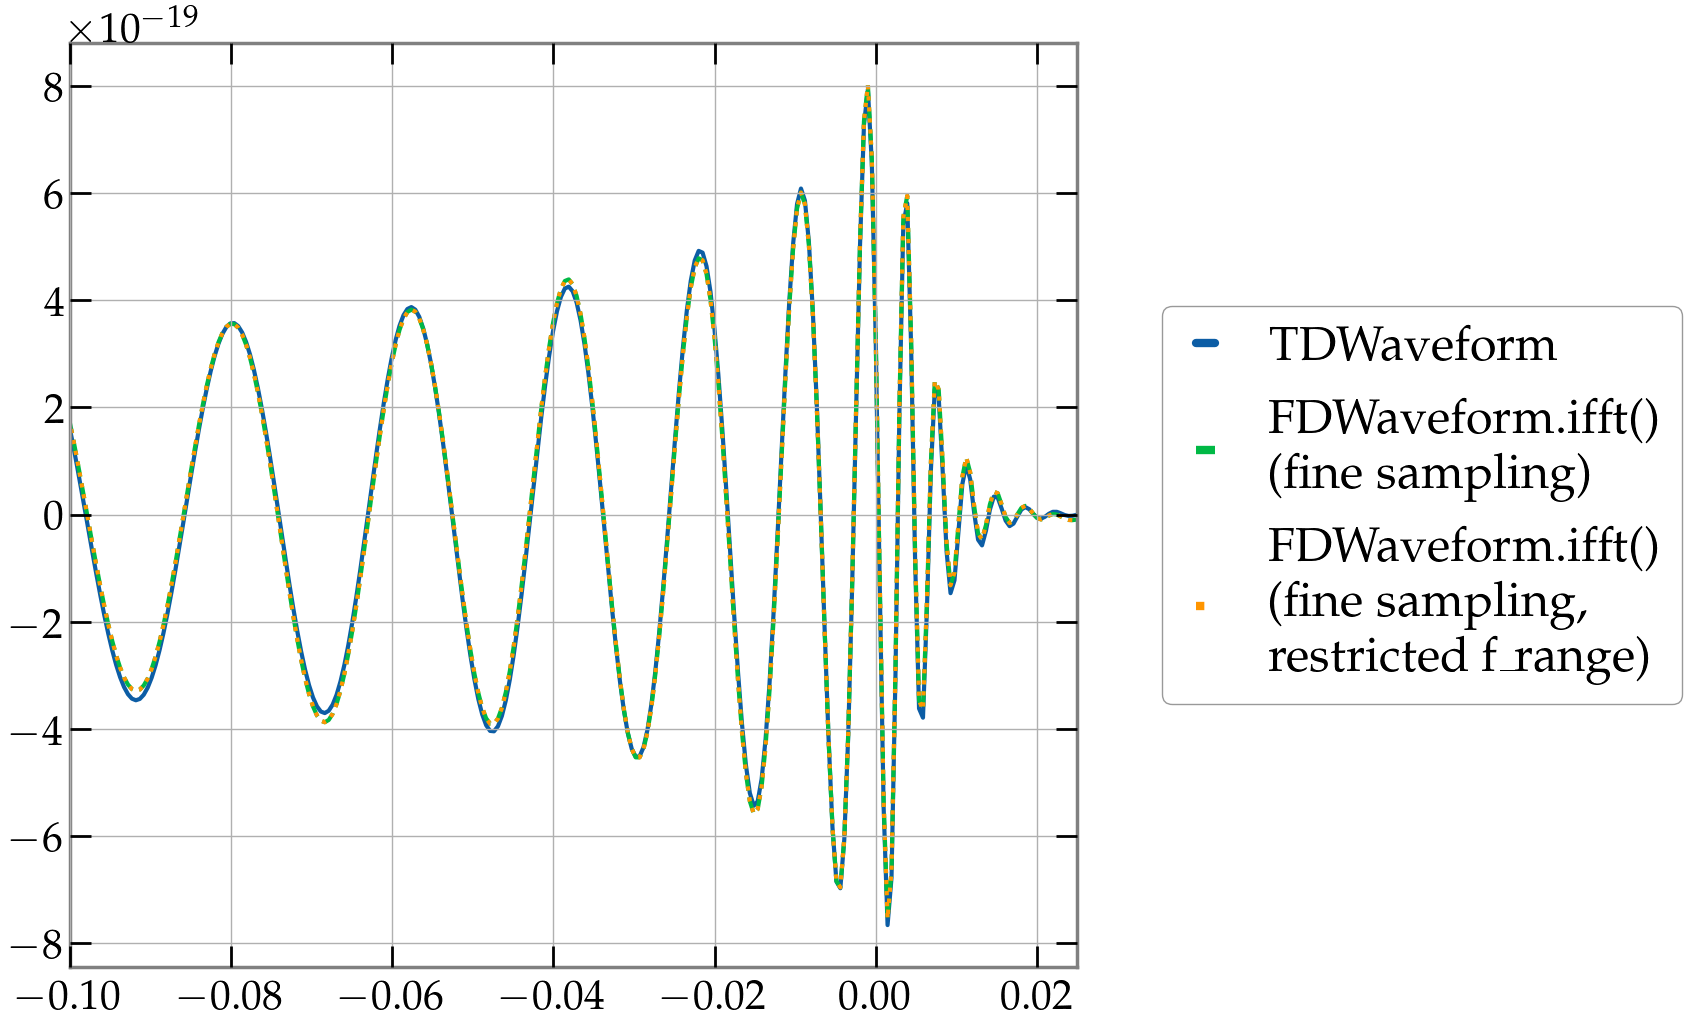

In [53]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_t_coarse_filtered, ':', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-0.1, 0.025])

plt.show()



fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_fine, '--', label='FDWaveform.ifft()\n(fine sampling)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

ax.set_xlim([-0.1, 0.025])

plt.show()

Clearly, removing some Fourier components and thus information has an impact on the Fourier transform of the coarsely sampled signal. For fine sampling, this impact is negligible.

-> now the effect of wrap-around dominates plot

Generally speaking, filtering also increases the phase shift observed most prominently at the beginning of the signal.

## Impact of Padding

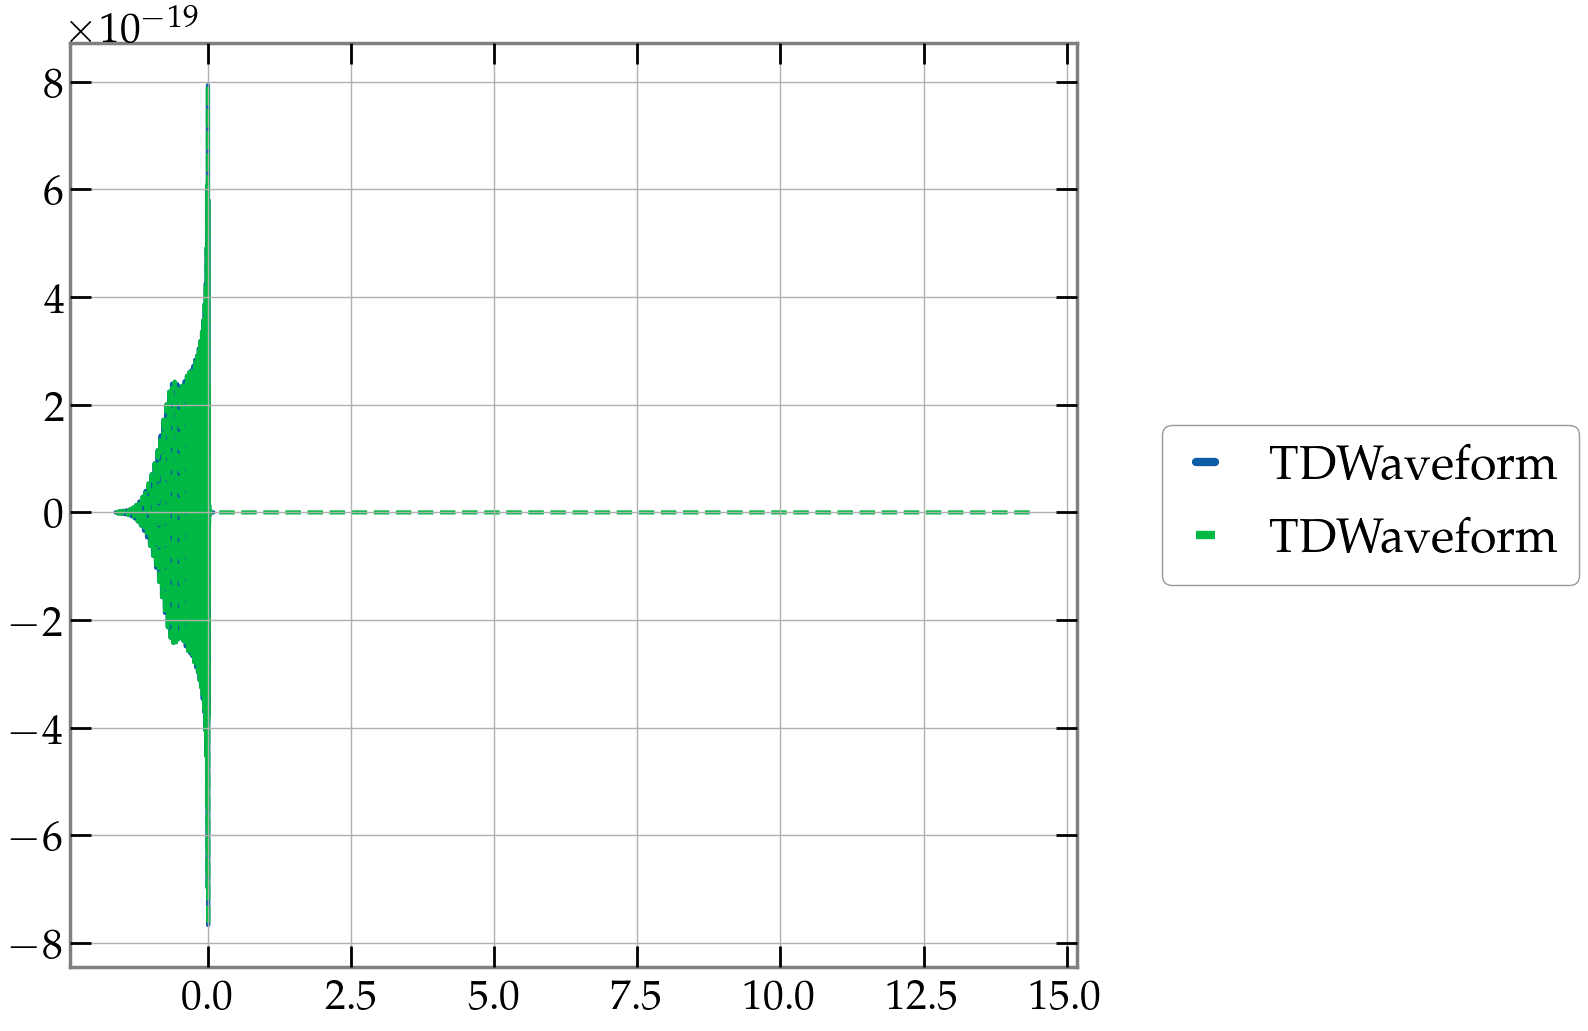

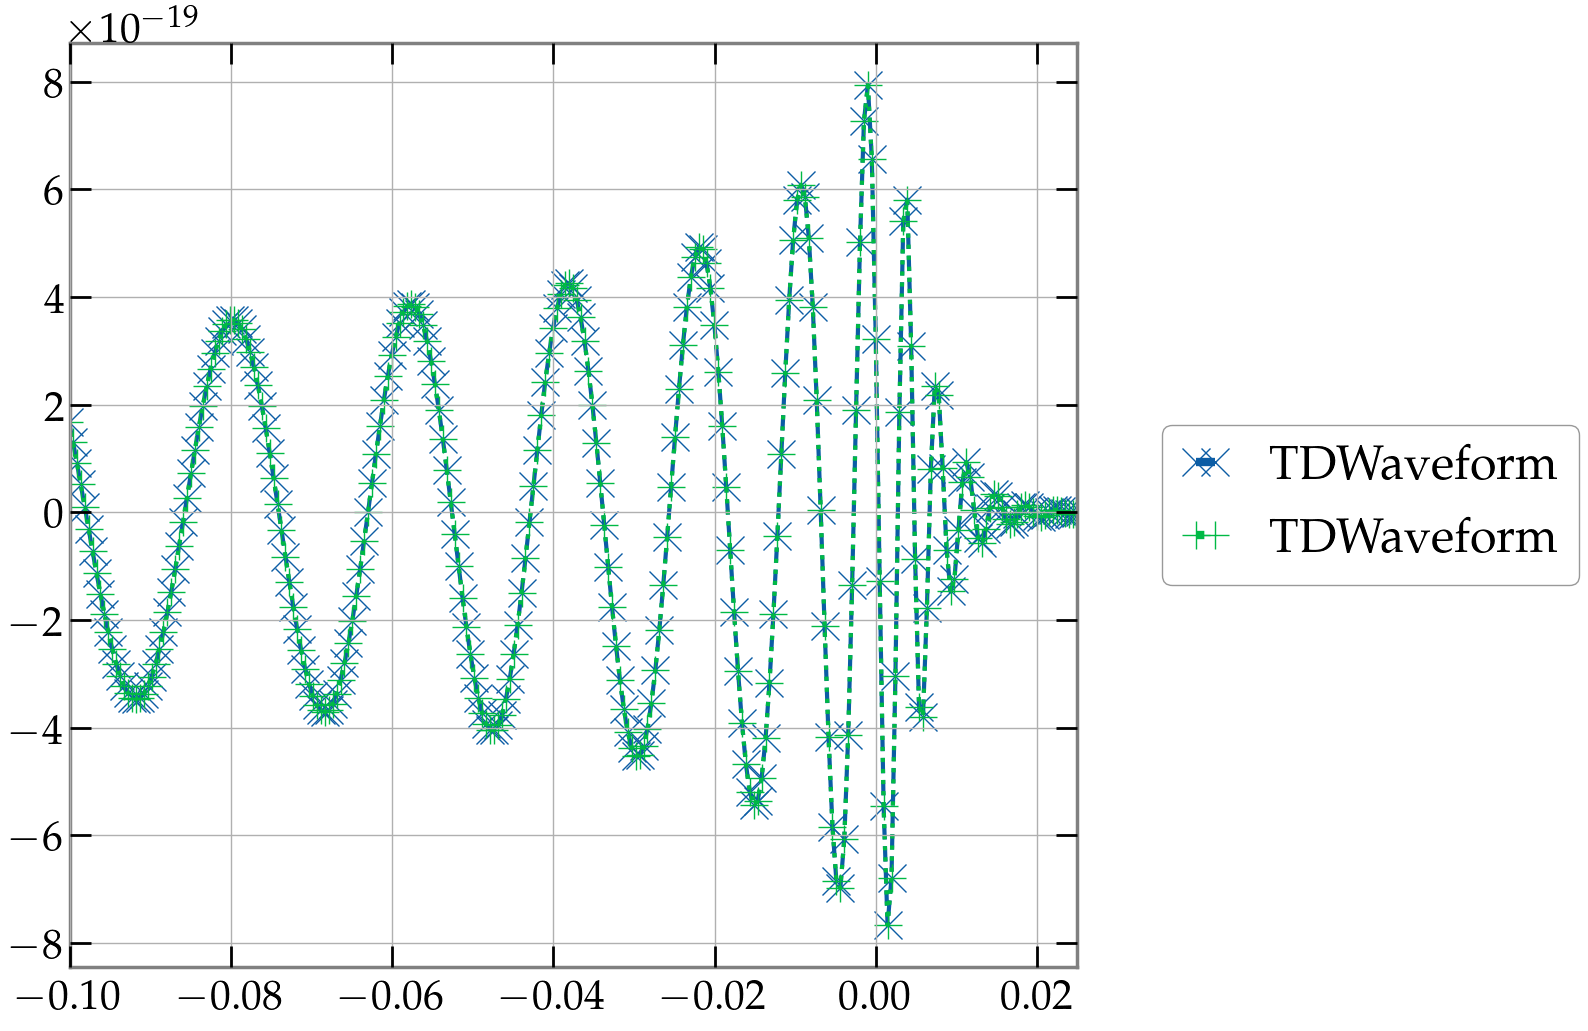

In [54]:
fig, ax = plt.subplots()

ax.plot(hp_t, label='TDWaveform')

ax.plot(pad_to_get_target_df(hp_t, df=0.0625 * u.Hz), '--', label='TDWaveform')

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

plt.show()



fig, ax = plt.subplots()

ax.plot(hp_t, 'x--', label='TDWaveform')

ax.plot(pad_to_get_target_df(hp_t, df=0.0625), '+:', label='TDWaveform')  # Input without unit works as well

ax.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

# ax.set_xlim([-1.5, 0.5])
ax.set_xlim([-0.1, 0.025])

plt.show()

Does exactly what it should do: increasing sample size by adding zeros after end of signal while leaving other samples untouched

## Impact of Interpolating

Deal with get_signal_at_target_df, get_signal_at_target_frequs

In [55]:
hp_f_even_finer = get_signal_at_target_df(hp_f_fine, hp_f_fine.df/2)

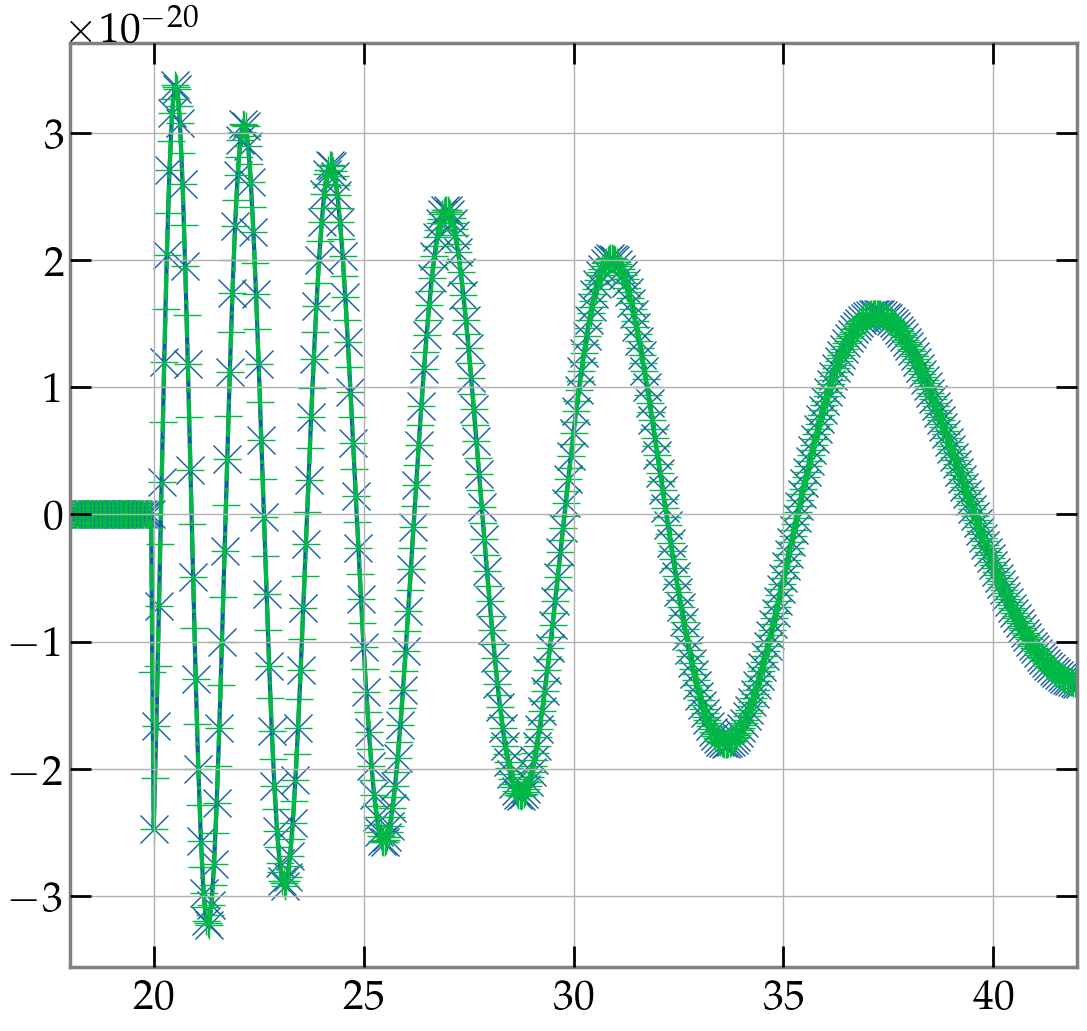

In [56]:
fig, ax = plt.subplots()

ax.plot(hp_f_fine, 'x-')
ax.plot(hp_f_even_finer, '+-.')

ax.set_xlim([18, 42])

plt.show()

In [57]:
# new_frequs = hp_f_fine.frequencies[(hp_f_fine.frequencies >= 30.*u.Hz) & (hp_f_fine.frequencies <= 40.*u.Hz)]
# new_frequs = np.arange(30, 40, step=hp_f_fine.df.value/2)*u.Hz
new_frequs = np.arange(30, 40, step=2.*hp_f_fine.df.value)*u.Hz

hp_f_cropped = get_signal_at_target_frequs(hp_f_fine, new_frequs)

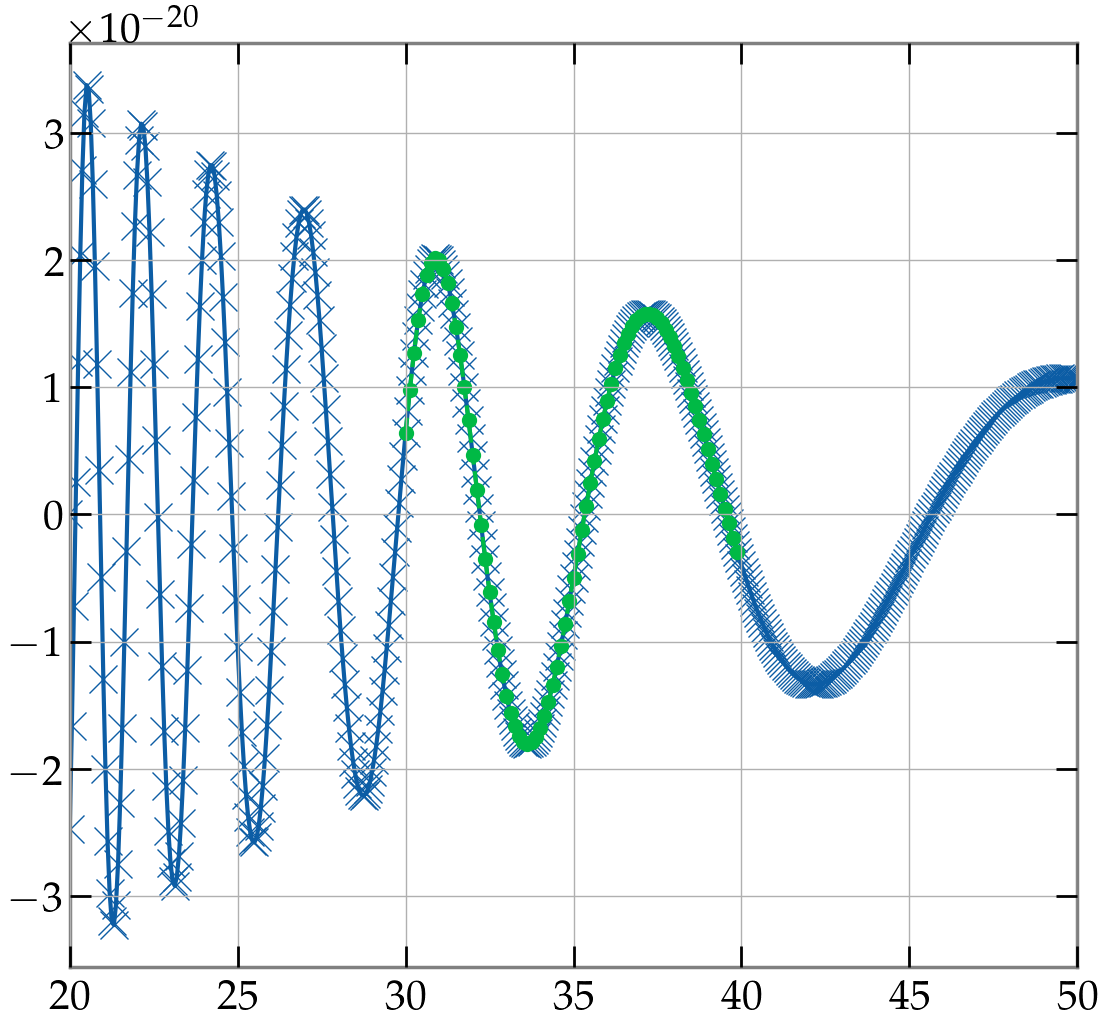

In [58]:
fig, ax = plt.subplots()

ax.plot(hp_f_fine, 'x-')
ax.plot(hp_f_cropped, '.--')

ax.set_xlim([20, 50])

plt.show()

In [59]:
hp_f_fine_2 = hp_f_fine.copy()
fill_f_range(hp_f_fine_2, 0., [30.*u.Hz, 50.*u.Hz])
# Note that a signal is returned, but ont setting new emphasizes inplace operation of signal

<FrequencySeries([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j,
                  0.+0.j]
                 unit=Unit("s"),
                 f0=<Quantity 0. Hz>,
                 df=<Quantity 0.0625 Hz>,
                 epoch=<Time object: scale='utc' format='gps' value=0.0>,
                 name='hplus',
                 channel=None)>

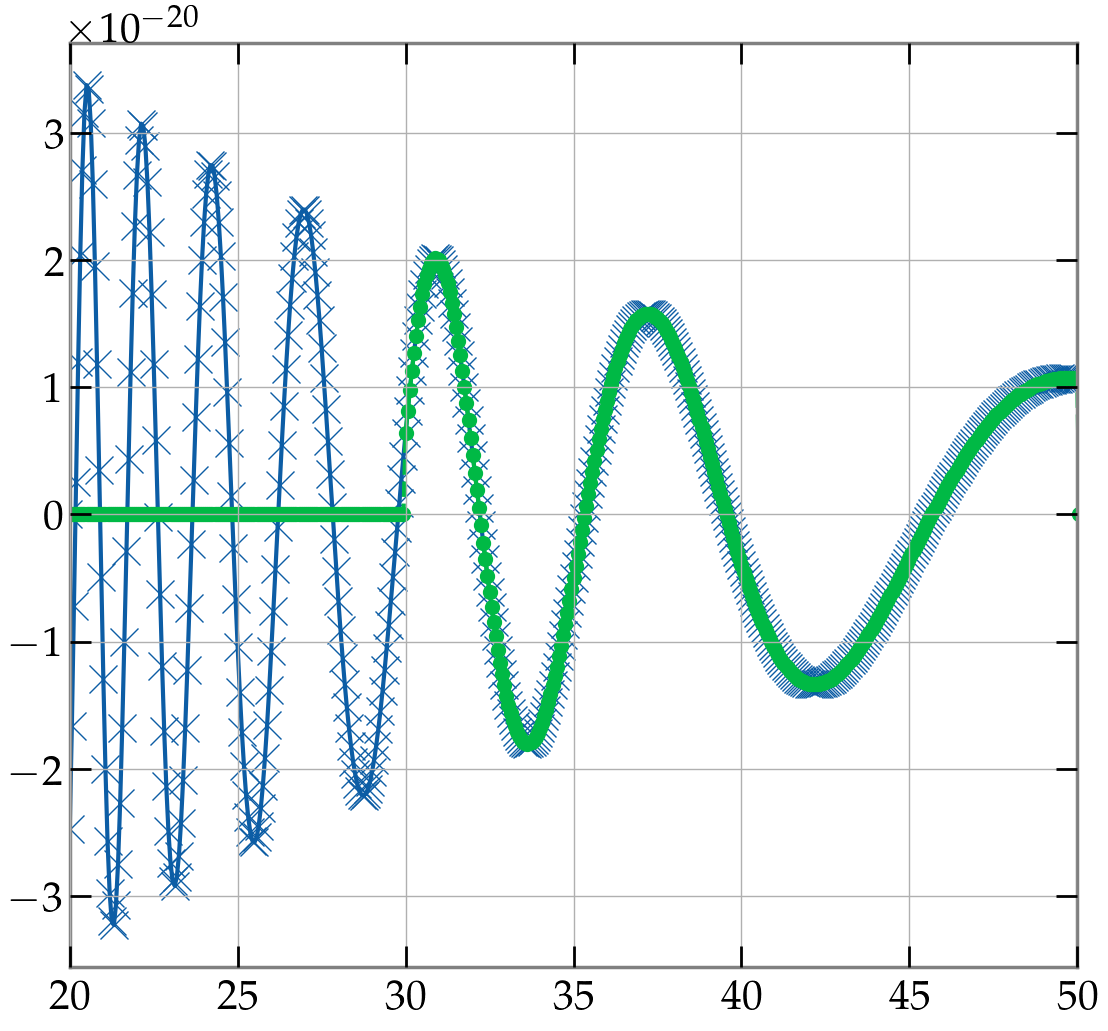

In [60]:
fig, ax = plt.subplots()

ax.plot(hp_f_fine, 'x-')
ax.plot(hp_f_fine_2, '.--')

ax.set_xlim([20, 50])

plt.show()

## Mass Scaling Verifications

In [61]:
from gw_signal_tools.waveform_utils import get_mass_scaled_wf

In [62]:
wf_center_parameters = parameters_gw150914.copy()

wf_center_parameters.pop('mass1')
wf_center_parameters.pop('mass2')

wf_center_parameters['total_mass'] = 100*u.solMass
wf_center_parameters['mass_ratio'] = 0.5*u.dimensionless_unscaled

wf_center_parameters['deltaF'] = 2**-6*u.Hz

### Frequency Domain

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

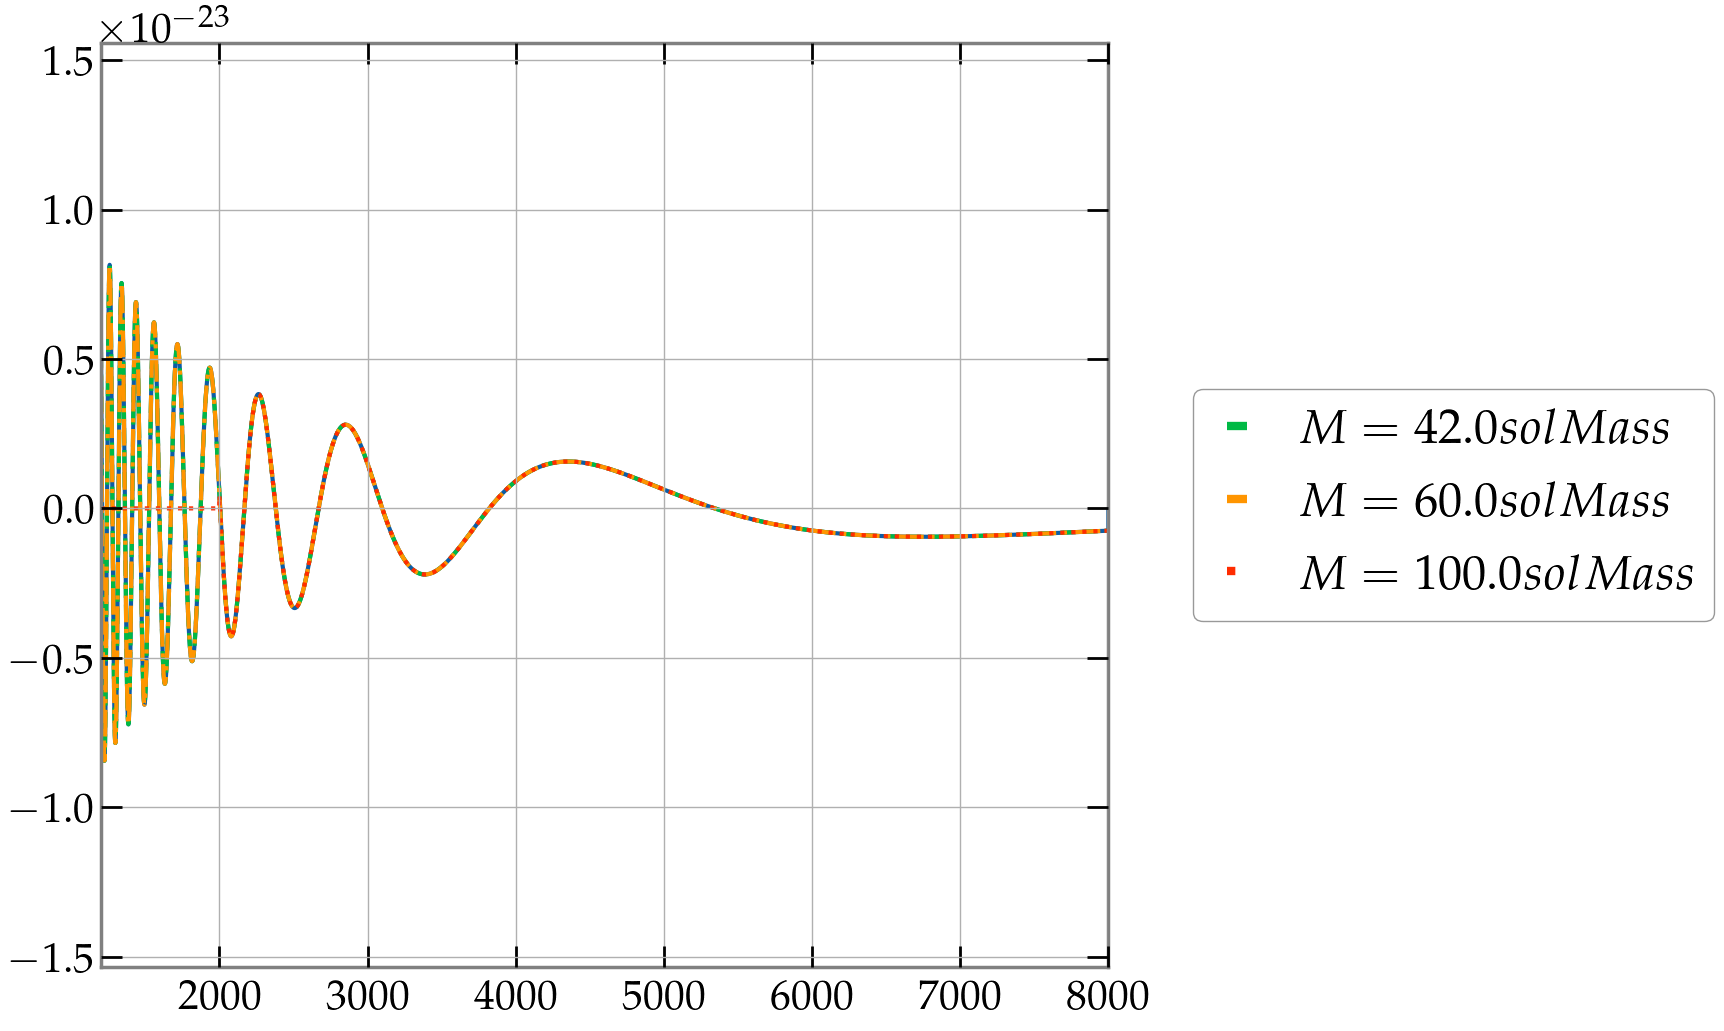

In [63]:
linestyles = ['-', '--', '-.', ':']

hp_f, _ = wfm.GenerateFDWaveform(wf_center_parameters | {'total_mass': 1.*u.solMass, 'f22_start': 800.*u.Hz, 'f_max': 8000.*u.Hz}, gen)
plt.plot(hp_f, linestyles[0])

for i, M in enumerate(u.Quantity([42.0, 60.0, 100.0], u.solMass)):
    hp_f, _ = get_mass_scaled_wf(wf_center_parameters | {'total_mass': M}, 'frequency', gen)
    
    plt.plot(np.real(hp_f), linestyles[i + 1], label=f'$M = {M}$')

plt.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

plt.xlim([1.2e3, 8e3])


plt.show()

### Time Domain

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

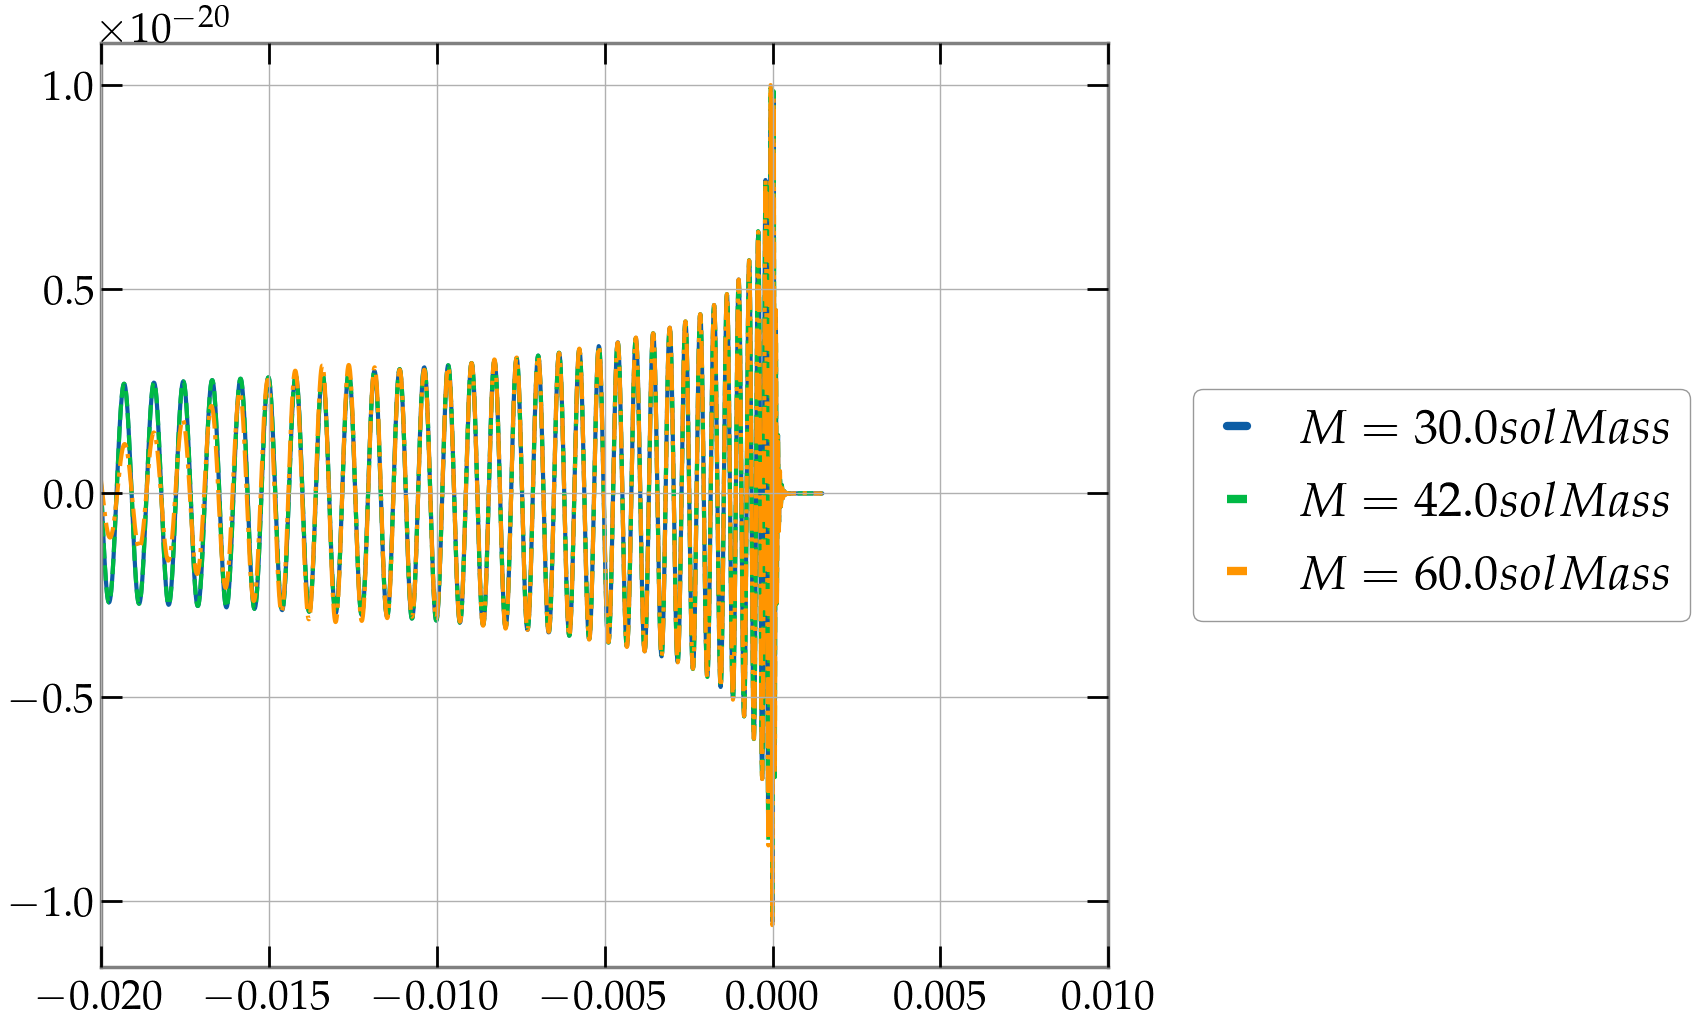

In [64]:
linestyles = ['-', '--', '-.', ':']


for i, M in enumerate(u.Quantity([30, 42, 60], u.solMass)):
    hp_t, _ = get_mass_scaled_wf(wf_center_parameters | {'total_mass': M}, 'time', gen)
    
    plt.plot(hp_t, linestyles[i], label=f'$M = {M}$')

plt.legend(bbox_to_anchor=(1.06, 0.5), loc='center left')

plt.xlim([-0.02, 0.01])


plt.show()

A note on this: Phenom waveforms are generated in frequency domain, so a Fourier transform and thus tapering is applied. Since we rescale after this transform, we effectively also change the interval over which tapering is applied, leading to the observed faster fall-off for higher masses.